# ECE239AS Midterm report
# Kai Fukami (UCLA)

In [1]:
from keras.layers import Input, Add, Dense, Conv2D, merge, Conv2DTranspose, MaxPooling2D, AveragePooling2D, UpSampling2D, Flatten, Reshape, LSTM
from keras.models import Model
from keras import backend as K
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})
plt.rc('text', usetex=True)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('font', family='Times New Roman')

Using TensorFlow backend.
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

In [4]:
import copy
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy as cp

In [45]:
def data_generator(tstep,y0,y1,force_idx):
    y = np.zeros((tstep)); u = np.zeros((tstep))
    y[0] = y0; y[1] = y1;
    u[0] = np.random.normal(0,0.04); 
    u[1] = np.random.normal(0,0.04);
    counter = 0
    if force_idx == True:
        for t in tqdm(range(2,tstep)):
            F = 0.8 - 0.5*np.exp(-(y[t-1])**2)*y[t-1]
            G = -(0.3+0.9*np.exp(-(y[t-1])**2))*y[t-2]
            H = u[t-1]+0.2*u[t-2]
            I = 0.1*u[t-1]*u[t-2]
            et = np.random.uniform()
            u[t] = np.random.normal(0,0.04)
            y[t] = F+G+H+I+et
    elif force_idx == False:
        for t in tqdm(range(2,tstep)):
            F = 0.8 - 0.5*np.exp(-(y[t-1])**2)*y[t-1]
            G = -(0.3+0.9*np.exp(-(y[t-1])**2))*y[t-2]
            y[t] = F+G
    return (y, u)

## Forced case

In [19]:
tstep = 500
y0 = 0.01; y1 = 0.1;
force_idx = True;
y_1,u_1 = data_generator(tstep,y0,y1,force_idx)

100%|██████████| 498/498 [00:00<00:00, 43662.35it/s]


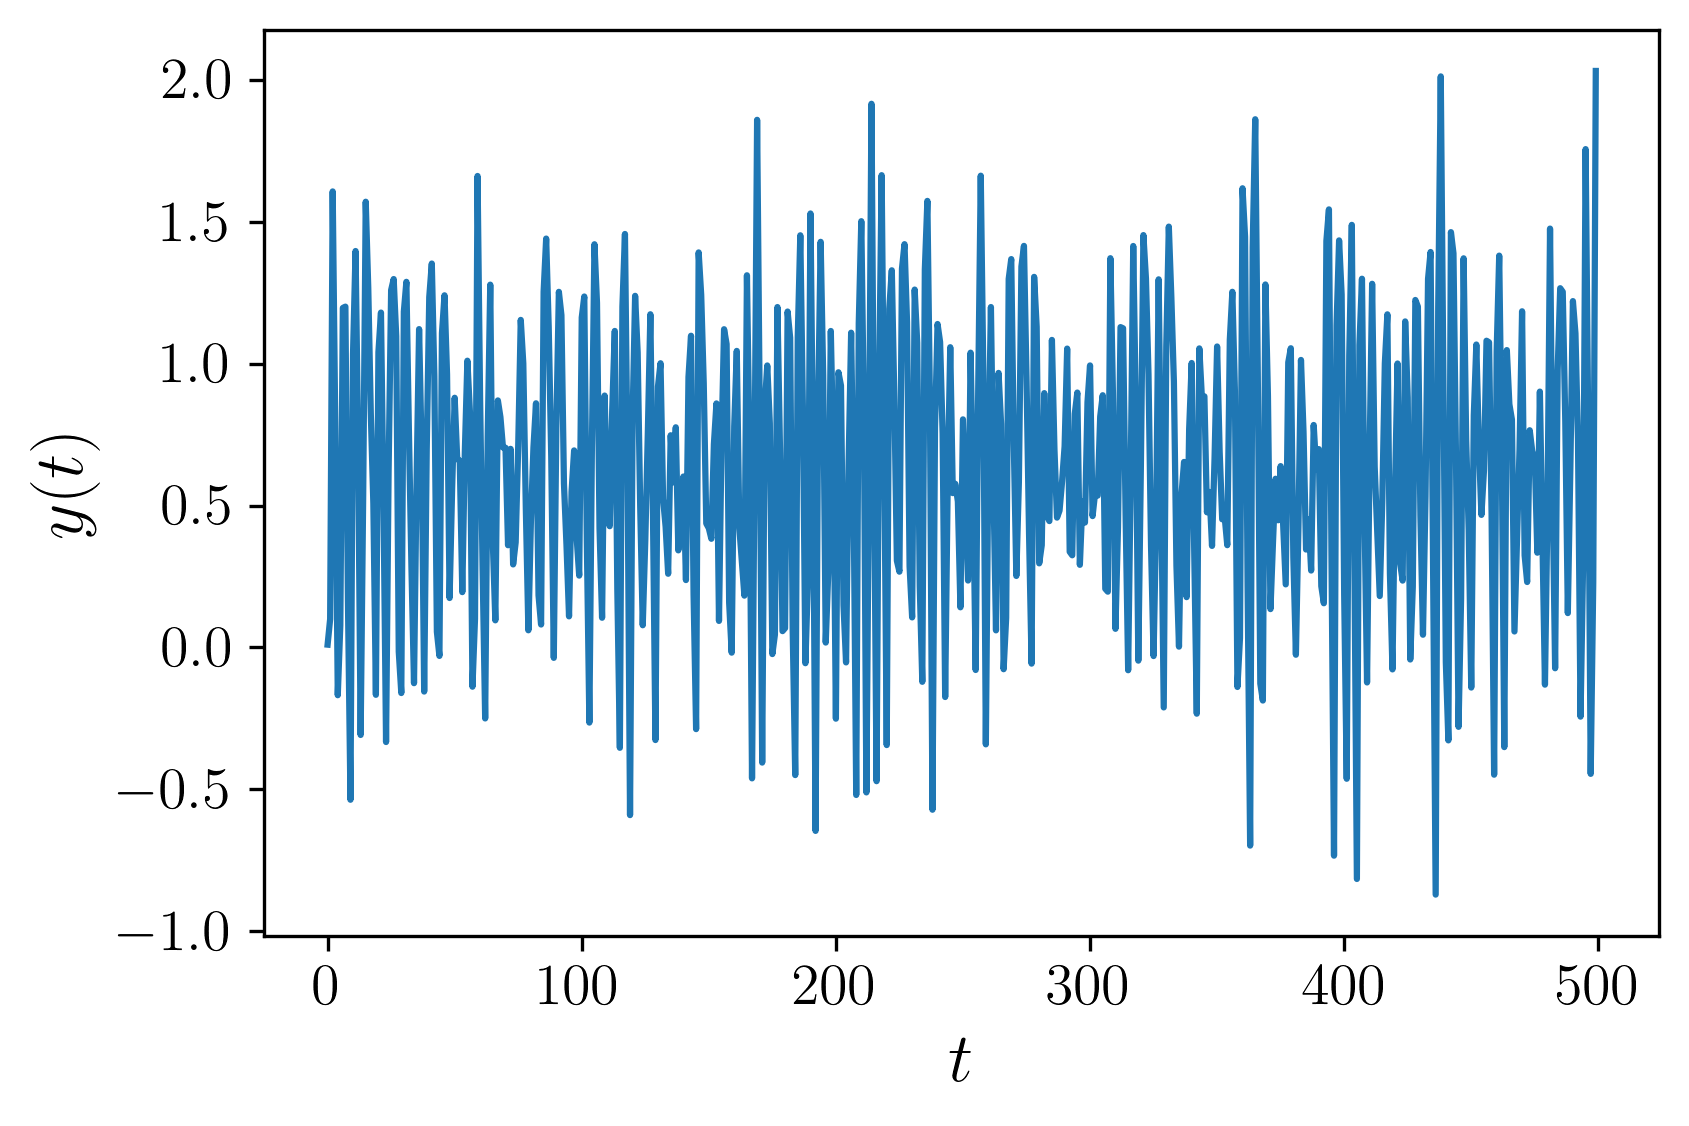

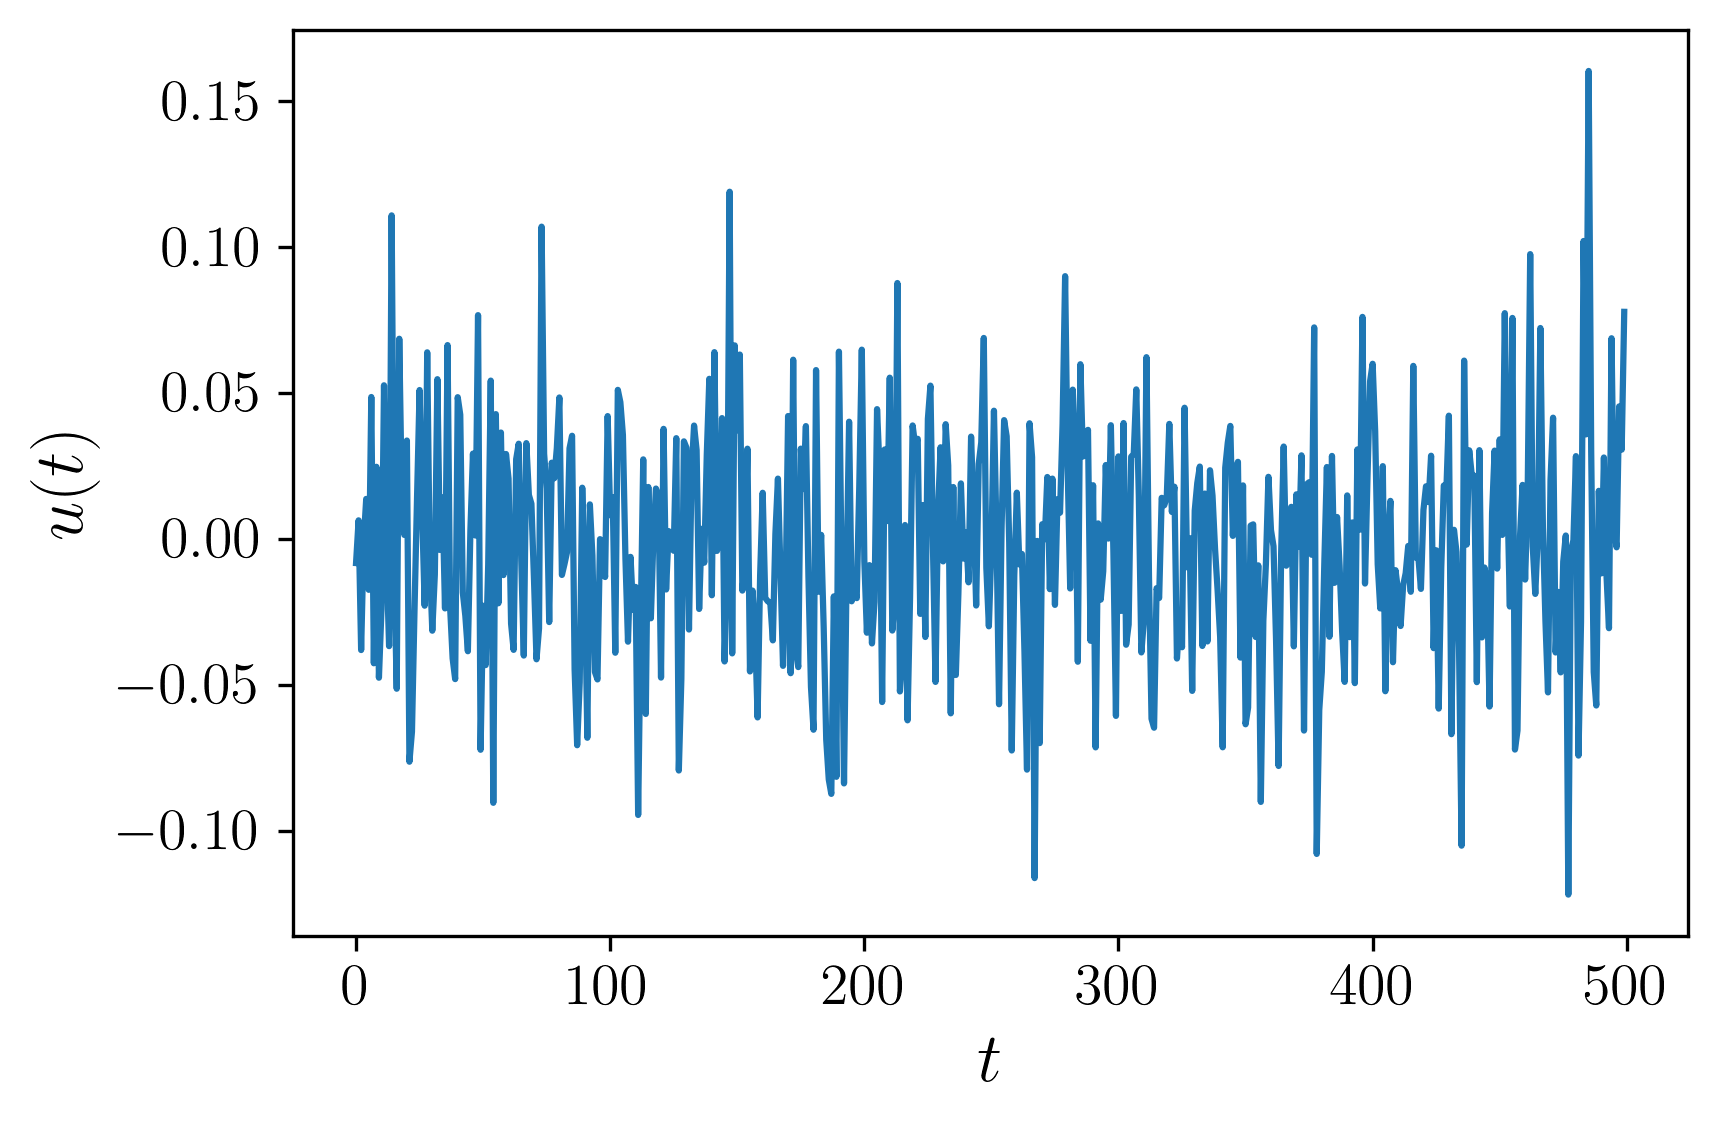

In [20]:
fig = plt.figure(dpi=300)
plt.plot(y_1)
plt.xlabel(r'$t$',fontsize=17)
plt.ylabel(r'$y(t)$',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

fig = plt.figure(dpi=300)
plt.plot(u_1)
plt.xlabel(r'$t$',fontsize=17)
plt.ylabel(r'$u(t)$',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [22]:
X_1 = np.zeros((tstep-2,4)) #y0,y1,u0,u1
X_1[:,0] = y_1[:(tstep-2)]
X_1[:,1] = y_1[1:(tstep-1)]
X_1[:,2] = u_1[:(tstep-2)]
X_1[:,3] = u_1[1:(tstep-1)]

X_2 = np.zeros((tstep-2,1))
X_2[:,0] = y_1[2:]

In [23]:
import copy
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy as cp



act = 'sigmoid'

input_img = Input(shape=(4,))
x1 = Dense(5, activation=act)(input_img)
x_final = Dense(1)(x1)
model = Model(input_img, x_final)
model.compile(optimizer='adam', loss='mse')


from keras.callbacks import ModelCheckpoint,EarlyStopping
X_train, X_val, y_train, y_val = train_test_split(X_1, X_2, test_size=0.3, random_state=None)

model_cb=ModelCheckpoint('./forced-model.hdf5', monitor='val_loss',save_best_only=True,verbose=1)
early_cb=EarlyStopping(monitor='val_loss', patience=100,verbose=1)
cb = [model_cb, early_cb]
history = model.fit(X_train,y_train,epochs=50000,batch_size=32,verbose=1,callbacks=cb,shuffle=True,validation_data=[X_val, y_val])
df_results = pd.DataFrame(history.history)
df_results['epoch'] = history.epoch
df_results.to_csv(path_or_buf='./forced-model.csv',index=False)

Train on 348 samples, validate on 150 samples
Epoch 1/50000
348/348 [==============================] - 1s 2ms/step - loss: 2.4230 - val_loss: 2.1624

Epoch 00001: val_loss improved from inf to 2.16236, saving model to ./forced-model.hdf5
Epoch 2/50000
348/348 [==============================] - 0s 131us/step - loss: 2.2651 - val_loss: 2.0125

Epoch 00002: val_loss improved from 2.16236 to 2.01255, saving model to ./forced-model.hdf5
Epoch 3/50000
348/348 [==============================] - 0s 127us/step - loss: 2.1134 - val_loss: 1.8708

Epoch 00003: val_loss improved from 2.01255 to 1.87078, saving model to ./forced-model.hdf5
Epoch 4/50000
348/348 [==============================] - 0s 135us/step - loss: 1.9715 - val_loss: 1.7383

Epoch 00004: val_loss improved from 1.87078 to 1.73833, saving model to ./forced-model.hdf5
Epoch 5/50000
348/348 [==============================] - 0s 128us/step - loss: 1.8360 - val_loss: 1.6166

Epoch 00005: val_loss improved from 1.73833 to 1.61655, saving

348/348 [==============================] - 0s 130us/step - loss: 0.2564 - val_loss: 0.2579

Epoch 00042: val_loss improved from 0.26105 to 0.25788, saving model to ./forced-model.hdf5
Epoch 43/50000
348/348 [==============================] - 0s 129us/step - loss: 0.2517 - val_loss: 0.2551

Epoch 00043: val_loss improved from 0.25788 to 0.25513, saving model to ./forced-model.hdf5
Epoch 44/50000
348/348 [==============================] - 0s 124us/step - loss: 0.2473 - val_loss: 0.2527

Epoch 00044: val_loss improved from 0.25513 to 0.25275, saving model to ./forced-model.hdf5
Epoch 45/50000
348/348 [==============================] - 0s 137us/step - loss: 0.2436 - val_loss: 0.2506

Epoch 00045: val_loss improved from 0.25275 to 0.25063, saving model to ./forced-model.hdf5
Epoch 46/50000
348/348 [==============================] - 0s 128us/step - loss: 0.2400 - val_loss: 0.2488

Epoch 00046: val_loss improved from 0.25063 to 0.24877, saving model to ./forced-model.hdf5
Epoch 47/50000
348/3

348/348 [==============================] - 0s 120us/step - loss: 0.1527 - val_loss: 0.1638

Epoch 00124: val_loss improved from 0.16449 to 0.16384, saving model to ./forced-model.hdf5
Epoch 125/50000
348/348 [==============================] - 0s 138us/step - loss: 0.1521 - val_loss: 0.1631

Epoch 00125: val_loss improved from 0.16384 to 0.16311, saving model to ./forced-model.hdf5
Epoch 126/50000
348/348 [==============================] - 0s 130us/step - loss: 0.1515 - val_loss: 0.1621

Epoch 00126: val_loss improved from 0.16311 to 0.16213, saving model to ./forced-model.hdf5
Epoch 127/50000
348/348 [==============================] - 0s 126us/step - loss: 0.1508 - val_loss: 0.1613

Epoch 00127: val_loss improved from 0.16213 to 0.16130, saving model to ./forced-model.hdf5
Epoch 128/50000
348/348 [==============================] - 0s 136us/step - loss: 0.1503 - val_loss: 0.1605

Epoch 00128: val_loss improved from 0.16130 to 0.16050, saving model to ./forced-model.hdf5
Epoch 129/50000


348/348 [==============================] - 0s 131us/step - loss: 0.1348 - val_loss: 0.1397

Epoch 00165: val_loss improved from 0.14025 to 0.13974, saving model to ./forced-model.hdf5
Epoch 166/50000
348/348 [==============================] - 0s 136us/step - loss: 0.1345 - val_loss: 0.1393

Epoch 00166: val_loss improved from 0.13974 to 0.13929, saving model to ./forced-model.hdf5
Epoch 167/50000
348/348 [==============================] - 0s 140us/step - loss: 0.1342 - val_loss: 0.1390

Epoch 00167: val_loss improved from 0.13929 to 0.13899, saving model to ./forced-model.hdf5
Epoch 168/50000
348/348 [==============================] - 0s 131us/step - loss: 0.1341 - val_loss: 0.1389

Epoch 00168: val_loss improved from 0.13899 to 0.13890, saving model to ./forced-model.hdf5
Epoch 169/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1337 - val_loss: 0.1384

Epoch 00169: val_loss improved from 0.13890 to 0.13838, saving model to ./forced-model.hdf5
Epoch 170/50000


348/348 [==============================] - 0s 126us/step - loss: 0.1280 - val_loss: 0.1297

Epoch 00206: val_loss improved from 0.12977 to 0.12970, saving model to ./forced-model.hdf5
Epoch 207/50000
348/348 [==============================] - 0s 129us/step - loss: 0.1279 - val_loss: 0.1297

Epoch 00207: val_loss improved from 0.12970 to 0.12965, saving model to ./forced-model.hdf5
Epoch 208/50000
348/348 [==============================] - 0s 169us/step - loss: 0.1278 - val_loss: 0.1294

Epoch 00208: val_loss improved from 0.12965 to 0.12938, saving model to ./forced-model.hdf5
Epoch 209/50000
348/348 [==============================] - 0s 138us/step - loss: 0.1277 - val_loss: 0.1292

Epoch 00209: val_loss improved from 0.12938 to 0.12919, saving model to ./forced-model.hdf5
Epoch 210/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1277 - val_loss: 0.1290

Epoch 00210: val_loss improved from 0.12919 to 0.12905, saving model to ./forced-model.hdf5
Epoch 211/50000


Epoch 250/50000
348/348 [==============================] - 0s 138us/step - loss: 0.1258 - val_loss: 0.1259

Epoch 00250: val_loss improved from 0.12590 to 0.12590, saving model to ./forced-model.hdf5
Epoch 251/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1257 - val_loss: 0.1259

Epoch 00251: val_loss did not improve from 0.12590
Epoch 252/50000
348/348 [==============================] - 0s 130us/step - loss: 0.1257 - val_loss: 0.1260

Epoch 00252: val_loss did not improve from 0.12590
Epoch 253/50000
348/348 [==============================] - 0s 126us/step - loss: 0.1257 - val_loss: 0.1257

Epoch 00253: val_loss improved from 0.12590 to 0.12574, saving model to ./forced-model.hdf5
Epoch 254/50000
348/348 [==============================] - 0s 142us/step - loss: 0.1256 - val_loss: 0.1256

Epoch 00254: val_loss improved from 0.12574 to 0.12561, saving model to ./forced-model.hdf5
Epoch 255/50000
348/348 [==============================] - 0s 129us/step - loss: 0


Epoch 00345: val_loss improved from 0.12309 to 0.12298, saving model to ./forced-model.hdf5
Epoch 346/50000
348/348 [==============================] - 0s 129us/step - loss: 0.1236 - val_loss: 0.1232

Epoch 00346: val_loss did not improve from 0.12298
Epoch 347/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1236 - val_loss: 0.1234

Epoch 00347: val_loss did not improve from 0.12298
Epoch 348/50000
348/348 [==============================] - 0s 133us/step - loss: 0.1236 - val_loss: 0.1233

Epoch 00348: val_loss did not improve from 0.12298
Epoch 349/50000
348/348 [==============================] - 0s 132us/step - loss: 0.1235 - val_loss: 0.1232

Epoch 00349: val_loss did not improve from 0.12298
Epoch 350/50000
348/348 [==============================] - 0s 133us/step - loss: 0.1235 - val_loss: 0.1231

Epoch 00350: val_loss did not improve from 0.12298
Epoch 351/50000
348/348 [==============================] - 0s 151us/step - loss: 0.1235 - val_loss: 0.1230

Epoc

Epoch 394/50000
348/348 [==============================] - 0s 137us/step - loss: 0.1225 - val_loss: 0.1221

Epoch 00394: val_loss did not improve from 0.12175
Epoch 395/50000
348/348 [==============================] - 0s 120us/step - loss: 0.1227 - val_loss: 0.1226

Epoch 00395: val_loss did not improve from 0.12175
Epoch 396/50000
348/348 [==============================] - 0s 128us/step - loss: 0.1226 - val_loss: 0.1221

Epoch 00396: val_loss did not improve from 0.12175
Epoch 397/50000
348/348 [==============================] - 0s 136us/step - loss: 0.1225 - val_loss: 0.1221

Epoch 00397: val_loss did not improve from 0.12175
Epoch 398/50000
348/348 [==============================] - 0s 139us/step - loss: 0.1225 - val_loss: 0.1221

Epoch 00398: val_loss did not improve from 0.12175
Epoch 399/50000
348/348 [==============================] - 0s 131us/step - loss: 0.1224 - val_loss: 0.1222

Epoch 00399: val_loss did not improve from 0.12175
Epoch 400/50000
348/348 [=====================

348/348 [==============================] - 0s 120us/step - loss: 0.1213 - val_loss: 0.1211

Epoch 00442: val_loss did not improve from 0.12067
Epoch 443/50000
348/348 [==============================] - 0s 119us/step - loss: 0.1213 - val_loss: 0.1209

Epoch 00443: val_loss did not improve from 0.12067
Epoch 444/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1212 - val_loss: 0.1207

Epoch 00444: val_loss did not improve from 0.12067
Epoch 445/50000
348/348 [==============================] - 0s 136us/step - loss: 0.1213 - val_loss: 0.1209

Epoch 00445: val_loss did not improve from 0.12067
Epoch 446/50000
348/348 [==============================] - 0s 126us/step - loss: 0.1212 - val_loss: 0.1207

Epoch 00446: val_loss did not improve from 0.12067
Epoch 447/50000
348/348 [==============================] - 0s 115us/step - loss: 0.1213 - val_loss: 0.1206

Epoch 00447: val_loss improved from 0.12067 to 0.12059, saving model to ./forced-model.hdf5
Epoch 448/50000
348/3

348/348 [==============================] - 0s 139us/step - loss: 0.1192 - val_loss: 0.1190

Epoch 00491: val_loss did not improve from 0.11892
Epoch 492/50000
348/348 [==============================] - 0s 136us/step - loss: 0.1192 - val_loss: 0.1191

Epoch 00492: val_loss did not improve from 0.11892
Epoch 493/50000
348/348 [==============================] - 0s 130us/step - loss: 0.1192 - val_loss: 0.1188

Epoch 00493: val_loss improved from 0.11892 to 0.11885, saving model to ./forced-model.hdf5
Epoch 494/50000
348/348 [==============================] - 0s 139us/step - loss: 0.1191 - val_loss: 0.1188

Epoch 00494: val_loss improved from 0.11885 to 0.11882, saving model to ./forced-model.hdf5
Epoch 495/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1191 - val_loss: 0.1189

Epoch 00495: val_loss did not improve from 0.11882
Epoch 496/50000
348/348 [==============================] - 0s 142us/step - loss: 0.1190 - val_loss: 0.1189

Epoch 00496: val_loss did not i

Epoch 537/50000
348/348 [==============================] - 0s 124us/step - loss: 0.1164 - val_loss: 0.1163

Epoch 00537: val_loss improved from 0.11650 to 0.11625, saving model to ./forced-model.hdf5
Epoch 538/50000
348/348 [==============================] - 0s 136us/step - loss: 0.1164 - val_loss: 0.1162

Epoch 00538: val_loss improved from 0.11625 to 0.11623, saving model to ./forced-model.hdf5
Epoch 539/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1163 - val_loss: 0.1162

Epoch 00539: val_loss did not improve from 0.11623
Epoch 540/50000
348/348 [==============================] - 0s 140us/step - loss: 0.1162 - val_loss: 0.1161

Epoch 00540: val_loss improved from 0.11623 to 0.11608, saving model to ./forced-model.hdf5
Epoch 541/50000
348/348 [==============================] - 0s 138us/step - loss: 0.1162 - val_loss: 0.1162

Epoch 00541: val_loss did not improve from 0.11608
Epoch 542/50000
348/348 [==============================] - 0s 144us/step - loss: 0

Epoch 630/50000
348/348 [==============================] - 0s 123us/step - loss: 0.1085 - val_loss: 0.1088

Epoch 00630: val_loss improved from 0.10900 to 0.10877, saving model to ./forced-model.hdf5
Epoch 631/50000
348/348 [==============================] - 0s 129us/step - loss: 0.1082 - val_loss: 0.1091

Epoch 00631: val_loss did not improve from 0.10877
Epoch 632/50000
348/348 [==============================] - 0s 123us/step - loss: 0.1083 - val_loss: 0.1094

Epoch 00632: val_loss did not improve from 0.10877
Epoch 633/50000
348/348 [==============================] - 0s 127us/step - loss: 0.1081 - val_loss: 0.1091

Epoch 00633: val_loss did not improve from 0.10877
Epoch 634/50000
348/348 [==============================] - 0s 117us/step - loss: 0.1080 - val_loss: 0.1088

Epoch 00634: val_loss improved from 0.10877 to 0.10875, saving model to ./forced-model.hdf5
Epoch 635/50000
348/348 [==============================] - 0s 143us/step - loss: 0.1079 - val_loss: 0.1087

Epoch 00635: va


Epoch 00677: val_loss did not improve from 0.10520
Epoch 678/50000
348/348 [==============================] - 0s 139us/step - loss: 0.1039 - val_loss: 0.1058

Epoch 00678: val_loss did not improve from 0.10520
Epoch 679/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1036 - val_loss: 0.1054

Epoch 00679: val_loss did not improve from 0.10520
Epoch 680/50000
348/348 [==============================] - 0s 135us/step - loss: 0.1035 - val_loss: 0.1052

Epoch 00680: val_loss improved from 0.10520 to 0.10516, saving model to ./forced-model.hdf5
Epoch 681/50000
348/348 [==============================] - 0s 136us/step - loss: 0.1036 - val_loss: 0.1046

Epoch 00681: val_loss improved from 0.10516 to 0.10458, saving model to ./forced-model.hdf5
Epoch 682/50000
348/348 [==============================] - 0s 134us/step - loss: 0.1035 - val_loss: 0.1048

Epoch 00682: val_loss did not improve from 0.10458
Epoch 683/50000
348/348 [==============================] - 0s 125us/ste

Epoch 725/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0994 - val_loss: 0.1015

Epoch 00725: val_loss improved from 0.10164 to 0.10149, saving model to ./forced-model.hdf5
Epoch 726/50000
348/348 [==============================] - 0s 136us/step - loss: 0.0994 - val_loss: 0.1016

Epoch 00726: val_loss did not improve from 0.10149
Epoch 727/50000
348/348 [==============================] - 0s 141us/step - loss: 0.0993 - val_loss: 0.1014

Epoch 00727: val_loss improved from 0.10149 to 0.10142, saving model to ./forced-model.hdf5
Epoch 728/50000
348/348 [==============================] - 0s 137us/step - loss: 0.0992 - val_loss: 0.1014

Epoch 00728: val_loss improved from 0.10142 to 0.10141, saving model to ./forced-model.hdf5
Epoch 729/50000
348/348 [==============================] - 0s 125us/step - loss: 0.0991 - val_loss: 0.1016

Epoch 00729: val_loss did not improve from 0.10141
Epoch 730/50000
348/348 [==============================] - 0s 123us/step - loss: 0

348/348 [==============================] - 0s 138us/step - loss: 0.0925 - val_loss: 0.0957

Epoch 00819: val_loss improved from 0.09605 to 0.09573, saving model to ./forced-model.hdf5
Epoch 820/50000
348/348 [==============================] - 0s 134us/step - loss: 0.0922 - val_loss: 0.0963

Epoch 00820: val_loss did not improve from 0.09573
Epoch 821/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0922 - val_loss: 0.0963

Epoch 00821: val_loss did not improve from 0.09573
Epoch 822/50000
348/348 [==============================] - 0s 129us/step - loss: 0.0921 - val_loss: 0.0960

Epoch 00822: val_loss did not improve from 0.09573
Epoch 823/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0922 - val_loss: 0.0964

Epoch 00823: val_loss did not improve from 0.09573
Epoch 824/50000
348/348 [==============================] - 0s 135us/step - loss: 0.0920 - val_loss: 0.0959

Epoch 00824: val_loss did not improve from 0.09573
Epoch 825/50000
348/3

Epoch 868/50000
348/348 [==============================] - 0s 120us/step - loss: 0.0896 - val_loss: 0.0944

Epoch 00868: val_loss did not improve from 0.09397
Epoch 869/50000
348/348 [==============================] - 0s 121us/step - loss: 0.0896 - val_loss: 0.0942

Epoch 00869: val_loss did not improve from 0.09397
Epoch 870/50000
348/348 [==============================] - 0s 129us/step - loss: 0.0895 - val_loss: 0.0940

Epoch 00870: val_loss improved from 0.09397 to 0.09396, saving model to ./forced-model.hdf5
Epoch 871/50000
348/348 [==============================] - 0s 148us/step - loss: 0.0895 - val_loss: 0.0939

Epoch 00871: val_loss improved from 0.09396 to 0.09391, saving model to ./forced-model.hdf5
Epoch 872/50000
348/348 [==============================] - 0s 136us/step - loss: 0.0894 - val_loss: 0.0940

Epoch 00872: val_loss did not improve from 0.09391
Epoch 873/50000
348/348 [==============================] - 0s 133us/step - loss: 0.0893 - val_loss: 0.0942

Epoch 00873: va

Epoch 916/50000
348/348 [==============================] - 0s 124us/step - loss: 0.0878 - val_loss: 0.0930

Epoch 00916: val_loss did not improve from 0.09252
Epoch 917/50000
348/348 [==============================] - 0s 123us/step - loss: 0.0877 - val_loss: 0.0928

Epoch 00917: val_loss did not improve from 0.09252
Epoch 918/50000
348/348 [==============================] - 0s 125us/step - loss: 0.0876 - val_loss: 0.0927

Epoch 00918: val_loss did not improve from 0.09252
Epoch 919/50000
348/348 [==============================] - 0s 143us/step - loss: 0.0876 - val_loss: 0.0929

Epoch 00919: val_loss did not improve from 0.09252
Epoch 920/50000
348/348 [==============================] - 0s 124us/step - loss: 0.0876 - val_loss: 0.0928

Epoch 00920: val_loss did not improve from 0.09252
Epoch 921/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0876 - val_loss: 0.0924

Epoch 00921: val_loss improved from 0.09252 to 0.09243, saving model to ./forced-model.hdf5
Epoch

348/348 [==============================] - 0s 126us/step - loss: 0.0863 - val_loss: 0.0920

Epoch 00966: val_loss did not improve from 0.09157
Epoch 967/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0865 - val_loss: 0.0915

Epoch 00967: val_loss improved from 0.09157 to 0.09149, saving model to ./forced-model.hdf5
Epoch 968/50000
348/348 [==============================] - 0s 134us/step - loss: 0.0863 - val_loss: 0.0921

Epoch 00968: val_loss did not improve from 0.09149
Epoch 969/50000
348/348 [==============================] - 0s 131us/step - loss: 0.0862 - val_loss: 0.0918

Epoch 00969: val_loss did not improve from 0.09149
Epoch 970/50000
348/348 [==============================] - 0s 143us/step - loss: 0.0862 - val_loss: 0.0918

Epoch 00970: val_loss did not improve from 0.09149
Epoch 971/50000
348/348 [==============================] - 0s 132us/step - loss: 0.0862 - val_loss: 0.0918

Epoch 00971: val_loss did not improve from 0.09149
Epoch 972/50000
348/3

348/348 [==============================] - 0s 128us/step - loss: 0.0847 - val_loss: 0.0909

Epoch 01066: val_loss did not improve from 0.09038
Epoch 1067/50000
348/348 [==============================] - 0s 125us/step - loss: 0.0847 - val_loss: 0.0908

Epoch 01067: val_loss did not improve from 0.09038
Epoch 1068/50000
348/348 [==============================] - 0s 129us/step - loss: 0.0847 - val_loss: 0.0910

Epoch 01068: val_loss did not improve from 0.09038
Epoch 1069/50000
348/348 [==============================] - 0s 133us/step - loss: 0.0847 - val_loss: 0.0905

Epoch 01069: val_loss did not improve from 0.09038
Epoch 1070/50000
348/348 [==============================] - 0s 123us/step - loss: 0.0847 - val_loss: 0.0905

Epoch 01070: val_loss did not improve from 0.09038
Epoch 1071/50000
348/348 [==============================] - 0s 126us/step - loss: 0.0847 - val_loss: 0.0904

Epoch 01071: val_loss did not improve from 0.09038
Epoch 1072/50000
348/348 [==============================]

348/348 [==============================] - 0s 136us/step - loss: 0.0844 - val_loss: 0.0909

Epoch 01116: val_loss did not improve from 0.09004
Epoch 1117/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0844 - val_loss: 0.0902

Epoch 01117: val_loss did not improve from 0.09004
Epoch 1118/50000
348/348 [==============================] - 0s 124us/step - loss: 0.0842 - val_loss: 0.0904

Epoch 01118: val_loss did not improve from 0.09004
Epoch 1119/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0842 - val_loss: 0.0905

Epoch 01119: val_loss did not improve from 0.09004
Epoch 1120/50000
348/348 [==============================] - 0s 138us/step - loss: 0.0843 - val_loss: 0.0901

Epoch 01120: val_loss did not improve from 0.09004
Epoch 1121/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0842 - val_loss: 0.0905

Epoch 01121: val_loss did not improve from 0.09004
Epoch 1122/50000
348/348 [==============================]

348/348 [==============================] - 0s 129us/step - loss: 0.0836 - val_loss: 0.0898

Epoch 01217: val_loss did not improve from 0.08965
Epoch 1218/50000
348/348 [==============================] - 0s 117us/step - loss: 0.0836 - val_loss: 0.0898

Epoch 01218: val_loss did not improve from 0.08965
Epoch 1219/50000
348/348 [==============================] - 0s 113us/step - loss: 0.0836 - val_loss: 0.0901

Epoch 01219: val_loss did not improve from 0.08965
Epoch 1220/50000
348/348 [==============================] - 0s 115us/step - loss: 0.0838 - val_loss: 0.0897

Epoch 01220: val_loss did not improve from 0.08965
Epoch 1221/50000
348/348 [==============================] - 0s 128us/step - loss: 0.0836 - val_loss: 0.0902

Epoch 01221: val_loss did not improve from 0.08965
Epoch 1222/50000
348/348 [==============================] - 0s 123us/step - loss: 0.0836 - val_loss: 0.0902

Epoch 01222: val_loss did not improve from 0.08965
Epoch 1223/50000
348/348 [==============================]

348/348 [==============================] - 0s 123us/step - loss: 0.0835 - val_loss: 0.0901

Epoch 01268: val_loss did not improve from 0.08950
Epoch 1269/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0835 - val_loss: 0.0902

Epoch 01269: val_loss did not improve from 0.08950
Epoch 1270/50000
348/348 [==============================] - 0s 124us/step - loss: 0.0835 - val_loss: 0.0896

Epoch 01270: val_loss did not improve from 0.08950
Epoch 1271/50000
348/348 [==============================] - 0s 135us/step - loss: 0.0834 - val_loss: 0.0897

Epoch 01271: val_loss did not improve from 0.08950
Epoch 1272/50000
348/348 [==============================] - 0s 126us/step - loss: 0.0834 - val_loss: 0.0897

Epoch 01272: val_loss did not improve from 0.08950
Epoch 1273/50000
348/348 [==============================] - 0s 125us/step - loss: 0.0834 - val_loss: 0.0900

Epoch 01273: val_loss did not improve from 0.08950
Epoch 1274/50000
348/348 [==============================]

348/348 [==============================] - 0s 138us/step - loss: 0.0832 - val_loss: 0.0897

Epoch 01319: val_loss did not improve from 0.08926
Epoch 1320/50000
348/348 [==============================] - 0s 133us/step - loss: 0.0832 - val_loss: 0.0898

Epoch 01320: val_loss did not improve from 0.08926
Epoch 1321/50000
348/348 [==============================] - 0s 137us/step - loss: 0.0832 - val_loss: 0.0896

Epoch 01321: val_loss did not improve from 0.08926
Epoch 1322/50000
348/348 [==============================] - 0s 132us/step - loss: 0.0832 - val_loss: 0.0899

Epoch 01322: val_loss did not improve from 0.08926
Epoch 1323/50000
348/348 [==============================] - 0s 132us/step - loss: 0.0832 - val_loss: 0.0899

Epoch 01323: val_loss did not improve from 0.08926
Epoch 1324/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0833 - val_loss: 0.0898

Epoch 01324: val_loss did not improve from 0.08926
Epoch 1325/50000
348/348 [==============================]

348/348 [==============================] - 0s 132us/step - loss: 0.0831 - val_loss: 0.0896

Epoch 01370: val_loss did not improve from 0.08913
Epoch 1371/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0830 - val_loss: 0.0896

Epoch 01371: val_loss did not improve from 0.08913
Epoch 1372/50000
348/348 [==============================] - 0s 129us/step - loss: 0.0830 - val_loss: 0.0897

Epoch 01372: val_loss did not improve from 0.08913
Epoch 1373/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0830 - val_loss: 0.0896

Epoch 01373: val_loss did not improve from 0.08913
Epoch 1374/50000
348/348 [==============================] - 0s 123us/step - loss: 0.0831 - val_loss: 0.0897

Epoch 01374: val_loss did not improve from 0.08913
Epoch 1375/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0830 - val_loss: 0.0895

Epoch 01375: val_loss did not improve from 0.08913
Epoch 1376/50000
348/348 [==============================]

348/348 [==============================] - 0s 129us/step - loss: 0.0827 - val_loss: 0.0894

Epoch 01472: val_loss did not improve from 0.08893
Epoch 1473/50000
348/348 [==============================] - 0s 131us/step - loss: 0.0827 - val_loss: 0.0896

Epoch 01473: val_loss did not improve from 0.08893
Epoch 1474/50000
348/348 [==============================] - 0s 125us/step - loss: 0.0827 - val_loss: 0.0894

Epoch 01474: val_loss did not improve from 0.08893
Epoch 1475/50000
348/348 [==============================] - 0s 133us/step - loss: 0.0827 - val_loss: 0.0893

Epoch 01475: val_loss did not improve from 0.08893
Epoch 1476/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0827 - val_loss: 0.0894

Epoch 01476: val_loss did not improve from 0.08893
Epoch 1477/50000
348/348 [==============================] - 0s 128us/step - loss: 0.0827 - val_loss: 0.0892

Epoch 01477: val_loss did not improve from 0.08893
Epoch 1478/50000
348/348 [==============================]

348/348 [==============================] - 0s 128us/step - loss: 0.0825 - val_loss: 0.0889

Epoch 01523: val_loss did not improve from 0.08882
Epoch 1524/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0827 - val_loss: 0.0894

Epoch 01524: val_loss did not improve from 0.08882
Epoch 1525/50000
348/348 [==============================] - 0s 123us/step - loss: 0.0827 - val_loss: 0.0890

Epoch 01525: val_loss did not improve from 0.08882
Epoch 1526/50000
348/348 [==============================] - 0s 124us/step - loss: 0.0825 - val_loss: 0.0892

Epoch 01526: val_loss did not improve from 0.08882
Epoch 1527/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0826 - val_loss: 0.0895

Epoch 01527: val_loss did not improve from 0.08882
Epoch 1528/50000
348/348 [==============================] - 0s 124us/step - loss: 0.0825 - val_loss: 0.0893

Epoch 01528: val_loss did not improve from 0.08882
Epoch 1529/50000
348/348 [==============================]

In [27]:
X_2_pred = model.predict(X_1,verbose=1)
X_2_pred_hat = np.zeros((tstep))
X_2_pred_hat[0] = y0; X_2_pred_hat[1] = y1;
u_hat = np.zeros((tstep))
for t in (range(len(u_hat))):
    u_hat[t] = np.random.normal(0,0.04);

for t in tqdm(range(len(X_2_pred)-2)):
    input_temp = np.zeros((1,4))
    input_temp[0,0] = X_2_pred_hat[t]
    input_temp[0,1] = X_2_pred_hat[t+1]
    input_temp[0,2] = u_hat[t]
    input_temp[0,3] = u_hat[t+1]
    X_2_pred_hat[t+2] = model.predict(input_temp)

498/498 [==============================] - 0s 20us/step


100%|██████████| 496/496 [00:00<00:00, 1403.10it/s]


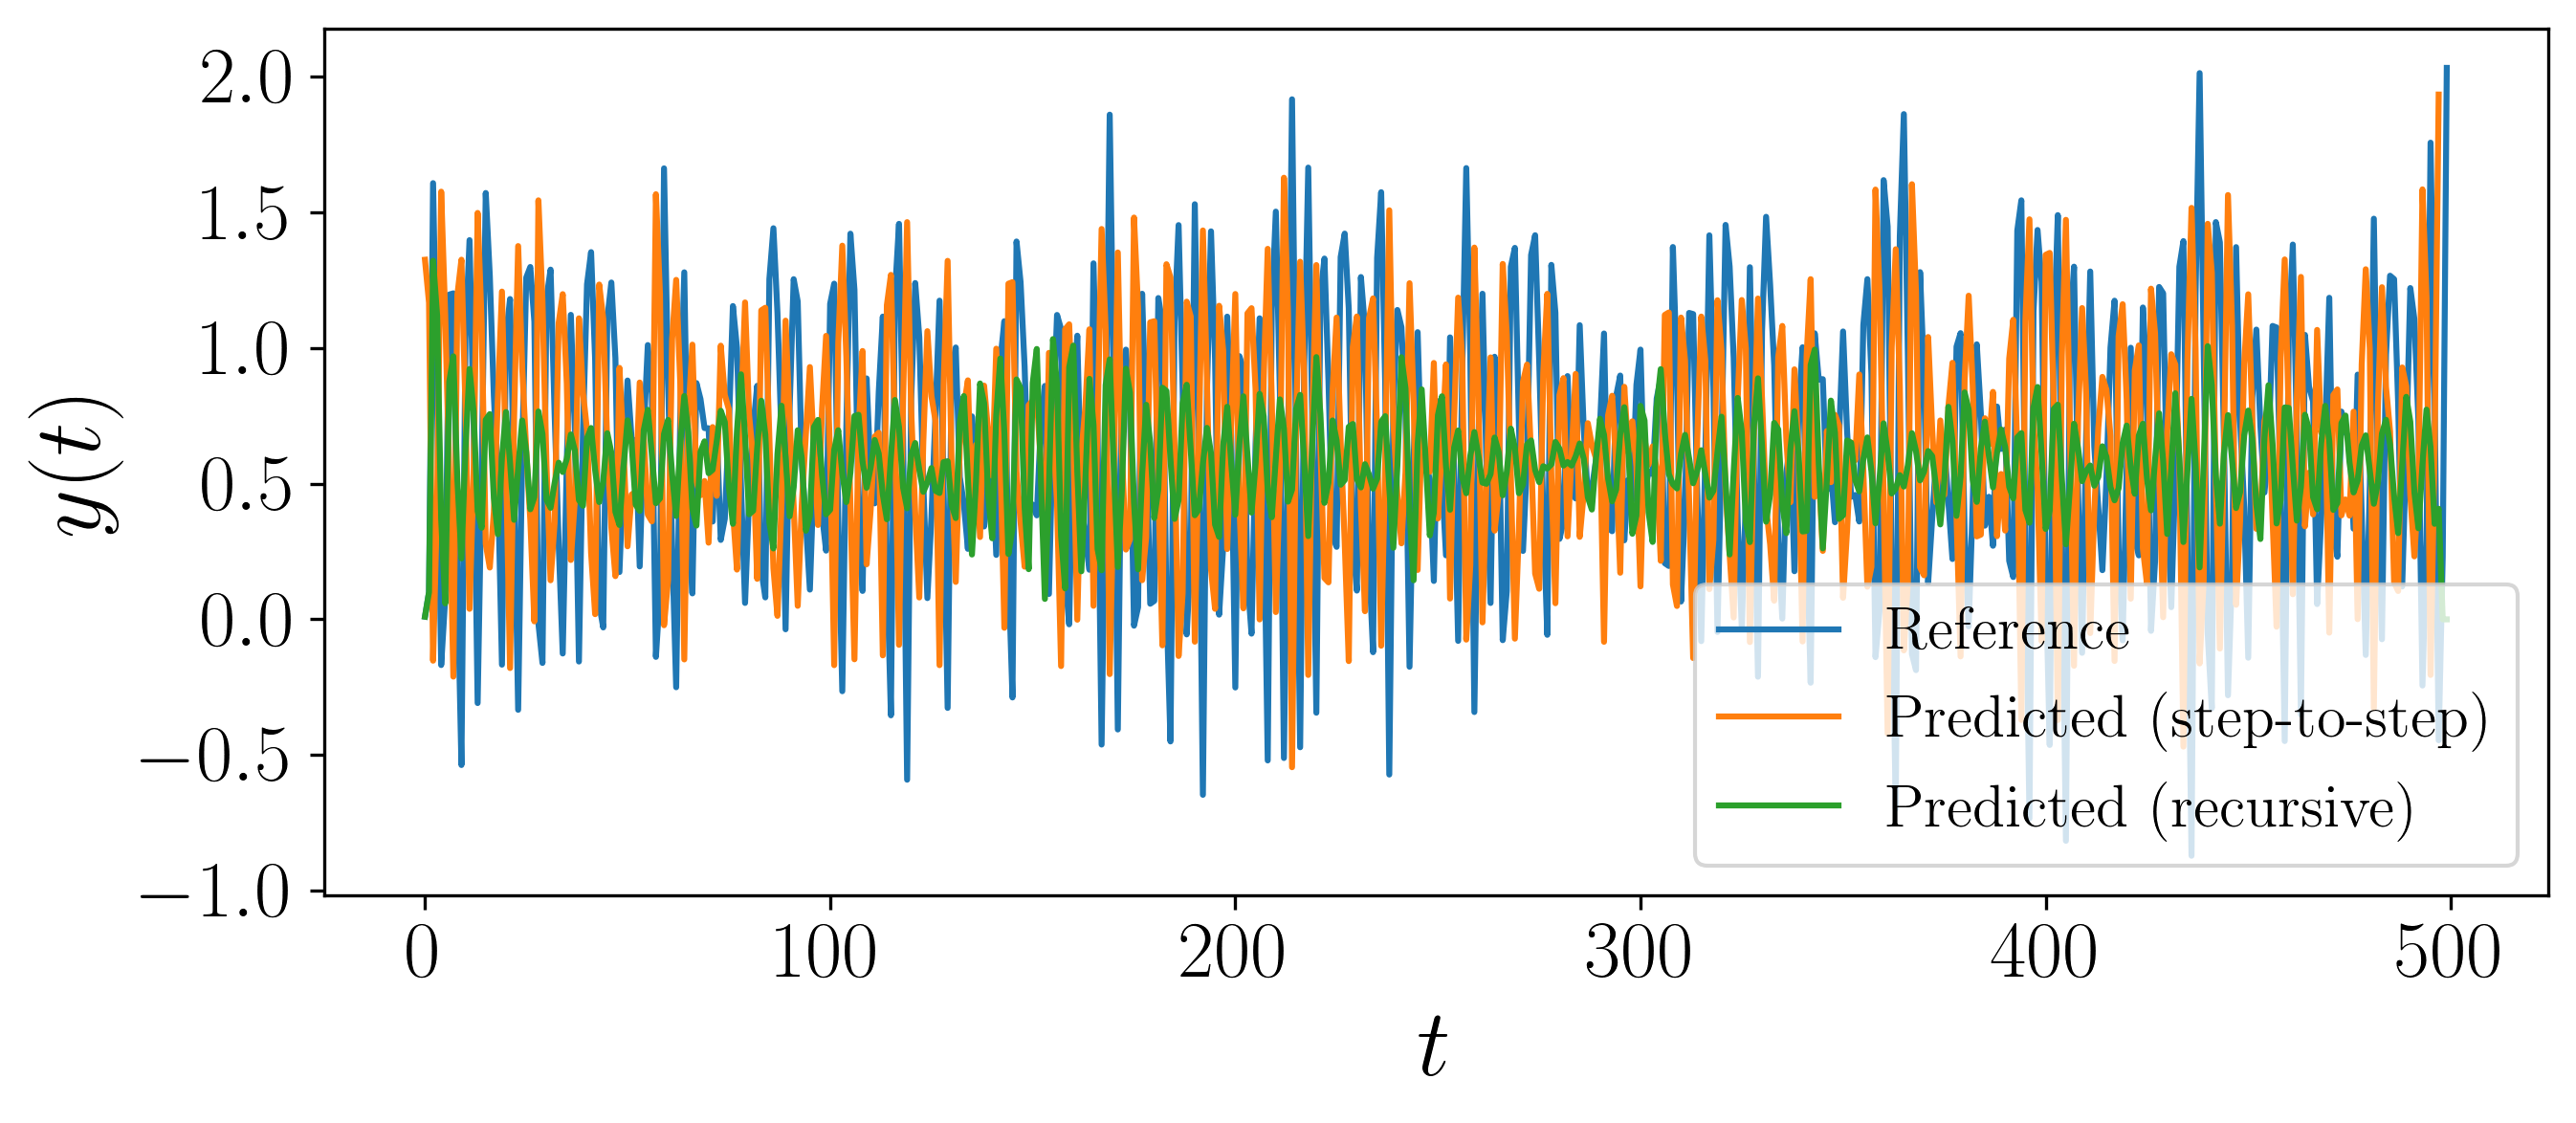

In [39]:
fig = plt.figure(dpi=300,figsize=(10,4))
plt.plot(y_1,label='Reference')
plt.plot(X_2_pred,label='Predicted (step-to-step)')
plt.plot(X_2_pred_hat,label='Predicted (recursive)')
plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$y(t)$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()

## Unforced case

In [46]:
tstep = 500
y0 = 0.01; y1 = 0.1;
force_idx = False;
y_1, u_1 = data_generator(tstep,y0,y1,force_idx)

100%|██████████| 498/498 [00:00<00:00, 56710.56it/s]


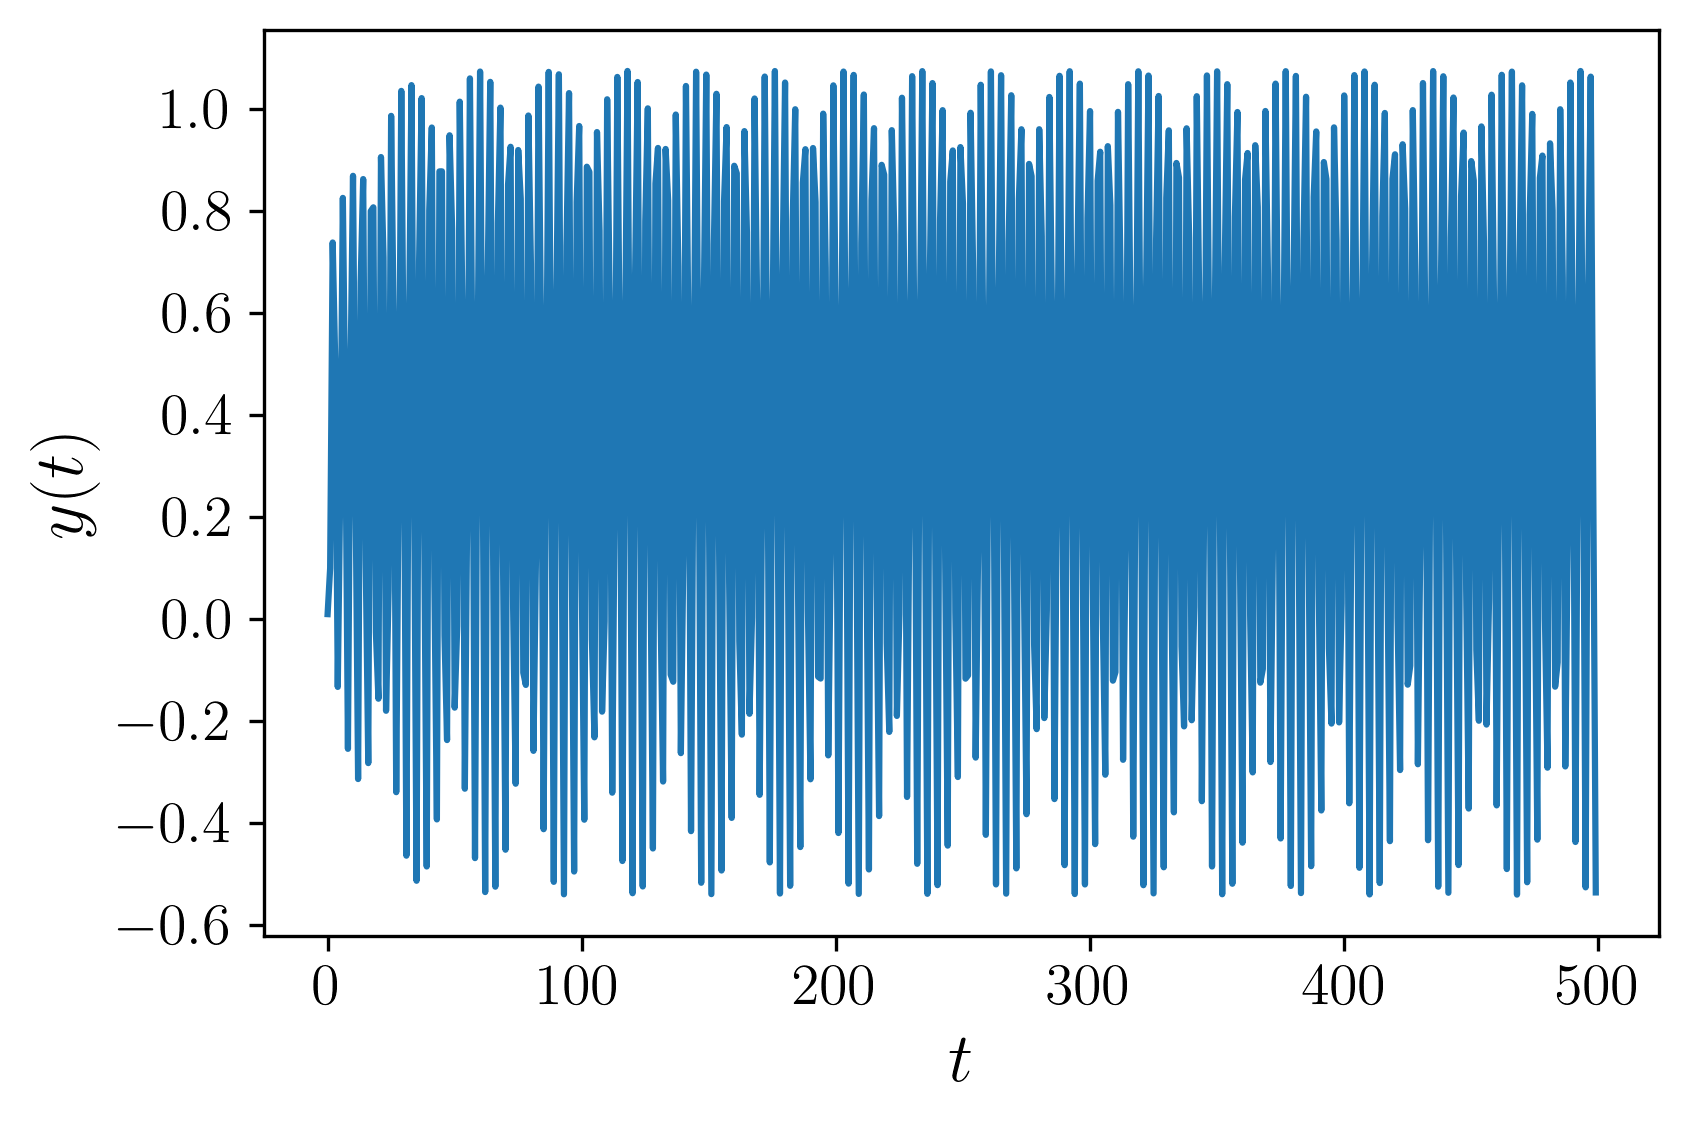

In [47]:
fig = plt.figure(dpi=300)
plt.plot(y_1)
plt.xlabel(r'$t$',fontsize=17)
plt.ylabel(r'$y(t)$',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [48]:
X_1 = np.zeros((tstep-2,2)) #y0,y1
X_1[:,0] = y_1[:(tstep-2)]
X_1[:,1] = y_1[1:(tstep-1)]

X_2 = np.zeros((tstep-2,1))
X_2[:,0] = y_1[2:]

In [49]:
import copy
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy as cp



act = 'sigmoid'

input_img = Input(shape=(2,))
x1 = Dense(10, activation=act)(input_img)
x_final = Dense(1)(x1)
model = Model(input_img, x_final)
model.compile(optimizer='adam', loss='mse')


from keras.callbacks import ModelCheckpoint,EarlyStopping
X_train, X_val, y_train, y_val = train_test_split(X_1, X_2, test_size=0.3, random_state=None)

model_cb=ModelCheckpoint('./unforced-model.hdf5', monitor='val_loss',save_best_only=True,verbose=1)
early_cb=EarlyStopping(monitor='val_loss', patience=100,verbose=1)
cb = [model_cb, early_cb]
history = model.fit(X_train,y_train,epochs=50000,batch_size=32,verbose=1,callbacks=cb,shuffle=True,validation_data=[X_val, y_val])
df_results = pd.DataFrame(history.history)
df_results['epoch'] = history.epoch
df_results.to_csv(path_or_buf='./unforced-model.csv',index=False)

Train on 348 samples, validate on 150 samples
Epoch 1/50000
348/348 [==============================] - 0s 916us/step - loss: 0.3704 - val_loss: 0.3467

Epoch 00001: val_loss improved from inf to 0.34674, saving model to ./unforced-model.hdf5
Epoch 2/50000
348/348 [==============================] - 0s 133us/step - loss: 0.3530 - val_loss: 0.3398

Epoch 00002: val_loss improved from 0.34674 to 0.33984, saving model to ./unforced-model.hdf5
Epoch 3/50000
348/348 [==============================] - 0s 132us/step - loss: 0.3418 - val_loss: 0.3349

Epoch 00003: val_loss improved from 0.33984 to 0.33494, saving model to ./unforced-model.hdf5
Epoch 4/50000
348/348 [==============================] - 0s 127us/step - loss: 0.3341 - val_loss: 0.3296

Epoch 00004: val_loss improved from 0.33494 to 0.32958, saving model to ./unforced-model.hdf5
Epoch 5/50000
348/348 [==============================] - 0s 131us/step - loss: 0.3272 - val_loss: 0.3240

Epoch 00005: val_loss improved from 0.32958 to 0.324

348/348 [==============================] - 0s 127us/step - loss: 0.1290 - val_loss: 0.1238

Epoch 00042: val_loss improved from 0.12808 to 0.12376, saving model to ./unforced-model.hdf5
Epoch 43/50000
348/348 [==============================] - 0s 131us/step - loss: 0.1248 - val_loss: 0.1193

Epoch 00043: val_loss improved from 0.12376 to 0.11930, saving model to ./unforced-model.hdf5
Epoch 44/50000
348/348 [==============================] - 0s 124us/step - loss: 0.1202 - val_loss: 0.1153

Epoch 00044: val_loss improved from 0.11930 to 0.11534, saving model to ./unforced-model.hdf5
Epoch 45/50000
348/348 [==============================] - 0s 125us/step - loss: 0.1161 - val_loss: 0.1109

Epoch 00045: val_loss improved from 0.11534 to 0.11093, saving model to ./unforced-model.hdf5
Epoch 46/50000
348/348 [==============================] - 0s 122us/step - loss: 0.1118 - val_loss: 0.1069

Epoch 00046: val_loss improved from 0.11093 to 0.10691, saving model to ./unforced-model.hdf5
Epoch 47/5

348/348 [==============================] - 0s 128us/step - loss: 0.0287 - val_loss: 0.0277

Epoch 00083: val_loss improved from 0.02819 to 0.02768, saving model to ./unforced-model.hdf5
Epoch 84/50000
348/348 [==============================] - 0s 134us/step - loss: 0.0281 - val_loss: 0.0272

Epoch 00084: val_loss improved from 0.02768 to 0.02724, saving model to ./unforced-model.hdf5
Epoch 85/50000
348/348 [==============================] - 0s 132us/step - loss: 0.0276 - val_loss: 0.0268

Epoch 00085: val_loss improved from 0.02724 to 0.02681, saving model to ./unforced-model.hdf5
Epoch 86/50000
348/348 [==============================] - 0s 133us/step - loss: 0.0272 - val_loss: 0.0265

Epoch 00086: val_loss improved from 0.02681 to 0.02647, saving model to ./unforced-model.hdf5
Epoch 87/50000
348/348 [==============================] - 0s 123us/step - loss: 0.0267 - val_loss: 0.0261

Epoch 00087: val_loss improved from 0.02647 to 0.02615, saving model to ./unforced-model.hdf5
Epoch 88/5

348/348 [==============================] - 0s 130us/step - loss: 0.0205 - val_loss: 0.0214

Epoch 00169: val_loss improved from 0.02144 to 0.02137, saving model to ./unforced-model.hdf5
Epoch 170/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0205 - val_loss: 0.0214

Epoch 00170: val_loss did not improve from 0.02137
Epoch 171/50000
348/348 [==============================] - 0s 138us/step - loss: 0.0204 - val_loss: 0.0212

Epoch 00171: val_loss improved from 0.02137 to 0.02121, saving model to ./unforced-model.hdf5
Epoch 172/50000
348/348 [==============================] - 0s 129us/step - loss: 0.0203 - val_loss: 0.0212

Epoch 00172: val_loss improved from 0.02121 to 0.02116, saving model to ./unforced-model.hdf5
Epoch 173/50000
348/348 [==============================] - 0s 144us/step - loss: 0.0203 - val_loss: 0.0211

Epoch 00173: val_loss improved from 0.02116 to 0.02112, saving model to ./unforced-model.hdf5
Epoch 174/50000
348/348 [========================

348/348 [==============================] - 0s 126us/step - loss: 0.0176 - val_loss: 0.0184

Epoch 00212: val_loss improved from 0.01848 to 0.01844, saving model to ./unforced-model.hdf5
Epoch 213/50000
348/348 [==============================] - 0s 133us/step - loss: 0.0175 - val_loss: 0.0184

Epoch 00213: val_loss improved from 0.01844 to 0.01837, saving model to ./unforced-model.hdf5
Epoch 214/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0175 - val_loss: 0.0183

Epoch 00214: val_loss improved from 0.01837 to 0.01827, saving model to ./unforced-model.hdf5
Epoch 215/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0174 - val_loss: 0.0182

Epoch 00215: val_loss improved from 0.01827 to 0.01824, saving model to ./unforced-model.hdf5
Epoch 216/50000
348/348 [==============================] - 0s 131us/step - loss: 0.0173 - val_loss: 0.0181

Epoch 00216: val_loss improved from 0.01824 to 0.01812, saving model to ./unforced-model.hdf5
Epoch 


Epoch 00253: val_loss improved from 0.01468 to 0.01457, saving model to ./unforced-model.hdf5
Epoch 254/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0138 - val_loss: 0.0145

Epoch 00254: val_loss improved from 0.01457 to 0.01447, saving model to ./unforced-model.hdf5
Epoch 255/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0137 - val_loss: 0.0144

Epoch 00255: val_loss improved from 0.01447 to 0.01438, saving model to ./unforced-model.hdf5
Epoch 256/50000
348/348 [==============================] - 0s 128us/step - loss: 0.0136 - val_loss: 0.0143

Epoch 00256: val_loss improved from 0.01438 to 0.01425, saving model to ./unforced-model.hdf5
Epoch 257/50000
348/348 [==============================] - 0s 137us/step - loss: 0.0135 - val_loss: 0.0142

Epoch 00257: val_loss improved from 0.01425 to 0.01422, saving model to ./unforced-model.hdf5
Epoch 258/50000
348/348 [==============================] - 0s 128us/step - loss: 0.0134 - val_los

348/348 [==============================] - 0s 125us/step - loss: 0.0095 - val_loss: 0.0101

Epoch 00295: val_loss improved from 0.01033 to 0.01012, saving model to ./unforced-model.hdf5
Epoch 296/50000
348/348 [==============================] - 0s 128us/step - loss: 0.0095 - val_loss: 0.0100

Epoch 00296: val_loss improved from 0.01012 to 0.01004, saving model to ./unforced-model.hdf5
Epoch 297/50000
348/348 [==============================] - 0s 124us/step - loss: 0.0094 - val_loss: 0.0100

Epoch 00297: val_loss improved from 0.01004 to 0.00999, saving model to ./unforced-model.hdf5
Epoch 298/50000
348/348 [==============================] - 0s 131us/step - loss: 0.0092 - val_loss: 0.0098

Epoch 00298: val_loss improved from 0.00999 to 0.00981, saving model to ./unforced-model.hdf5
Epoch 299/50000
348/348 [==============================] - 0s 132us/step - loss: 0.0092 - val_loss: 0.0097

Epoch 00299: val_loss improved from 0.00981 to 0.00974, saving model to ./unforced-model.hdf5
Epoch 


Epoch 00377: val_loss improved from 0.00356 to 0.00355, saving model to ./unforced-model.hdf5
Epoch 378/50000
348/348 [==============================] - 0s 128us/step - loss: 0.0032 - val_loss: 0.0034

Epoch 00378: val_loss improved from 0.00355 to 0.00345, saving model to ./unforced-model.hdf5
Epoch 379/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0032 - val_loss: 0.0035

Epoch 00379: val_loss did not improve from 0.00345
Epoch 380/50000
348/348 [==============================] - 0s 133us/step - loss: 0.0031 - val_loss: 0.0034

Epoch 00380: val_loss improved from 0.00345 to 0.00341, saving model to ./unforced-model.hdf5
Epoch 381/50000
348/348 [==============================] - 0s 126us/step - loss: 0.0031 - val_loss: 0.0033

Epoch 00381: val_loss improved from 0.00341 to 0.00332, saving model to ./unforced-model.hdf5
Epoch 382/50000
348/348 [==============================] - 0s 141us/step - loss: 0.0030 - val_loss: 0.0033

Epoch 00382: val_loss improved f

Epoch 420/50000
348/348 [==============================] - 0s 141us/step - loss: 0.0019 - val_loss: 0.0021

Epoch 00420: val_loss did not improve from 0.00205
Epoch 421/50000
348/348 [==============================] - 0s 129us/step - loss: 0.0019 - val_loss: 0.0020

Epoch 00421: val_loss improved from 0.00205 to 0.00202, saving model to ./unforced-model.hdf5
Epoch 422/50000
348/348 [==============================] - 0s 123us/step - loss: 0.0019 - val_loss: 0.0020

Epoch 00422: val_loss did not improve from 0.00202
Epoch 423/50000
348/348 [==============================] - 0s 124us/step - loss: 0.0019 - val_loss: 0.0020

Epoch 00423: val_loss improved from 0.00202 to 0.00198, saving model to ./unforced-model.hdf5
Epoch 424/50000
348/348 [==============================] - 0s 125us/step - loss: 0.0019 - val_loss: 0.0020

Epoch 00424: val_loss improved from 0.00198 to 0.00195, saving model to ./unforced-model.hdf5
Epoch 425/50000
348/348 [==============================] - 0s 131us/step - l

348/348 [==============================] - 0s 133us/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00509: val_loss did not improve from 0.00115
Epoch 510/50000
348/348 [==============================] - 0s 139us/step - loss: 0.0012 - val_loss: 0.0011

Epoch 00510: val_loss improved from 0.00115 to 0.00114, saving model to ./unforced-model.hdf5
Epoch 511/50000
348/348 [==============================] - 0s 130us/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00511: val_loss did not improve from 0.00114
Epoch 512/50000
348/348 [==============================] - 0s 128us/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00512: val_loss did not improve from 0.00114
Epoch 513/50000
348/348 [==============================] - 0s 122us/step - loss: 0.0012 - val_loss: 0.0011

Epoch 00513: val_loss improved from 0.00114 to 0.00113, saving model to ./unforced-model.hdf5
Epoch 514/50000
348/348 [==============================] - 0s 126us/step - loss: 0.0012 - val_loss: 0.0011

Epoch 00514: val_loss impro

Epoch 555/50000
348/348 [==============================] - 0s 133us/step - loss: 9.9193e-04 - val_loss: 0.0010

Epoch 00555: val_loss did not improve from 0.00096
Epoch 556/50000
348/348 [==============================] - 0s 126us/step - loss: 9.9880e-04 - val_loss: 9.6456e-04

Epoch 00556: val_loss did not improve from 0.00096
Epoch 557/50000
348/348 [==============================] - 0s 127us/step - loss: 0.0010 - val_loss: 9.9830e-04

Epoch 00557: val_loss did not improve from 0.00096
Epoch 558/50000
348/348 [==============================] - 0s 120us/step - loss: 0.0010 - val_loss: 9.5048e-04

Epoch 00558: val_loss improved from 0.00096 to 0.00095, saving model to ./unforced-model.hdf5
Epoch 559/50000
348/348 [==============================] - 0s 128us/step - loss: 9.7928e-04 - val_loss: 9.7798e-04

Epoch 00559: val_loss did not improve from 0.00095
Epoch 560/50000
348/348 [==============================] - 0s 131us/step - loss: 9.8711e-04 - val_loss: 9.5402e-04

Epoch 00560: val_l

Epoch 600/50000
348/348 [==============================] - 0s 122us/step - loss: 8.4083e-04 - val_loss: 8.2463e-04

Epoch 00600: val_loss did not improve from 0.00081
Epoch 601/50000
348/348 [==============================] - 0s 127us/step - loss: 8.4242e-04 - val_loss: 7.9932e-04

Epoch 00601: val_loss improved from 0.00081 to 0.00080, saving model to ./unforced-model.hdf5
Epoch 602/50000
348/348 [==============================] - 0s 126us/step - loss: 8.3759e-04 - val_loss: 8.0923e-04

Epoch 00602: val_loss did not improve from 0.00080
Epoch 603/50000
348/348 [==============================] - 0s 134us/step - loss: 8.2796e-04 - val_loss: 8.0933e-04

Epoch 00603: val_loss did not improve from 0.00080
Epoch 604/50000
348/348 [==============================] - 0s 135us/step - loss: 8.3475e-04 - val_loss: 8.0450e-04

Epoch 00604: val_loss did not improve from 0.00080
Epoch 605/50000
348/348 [==============================] - 0s 132us/step - loss: 8.2350e-04 - val_loss: 7.8825e-04

Epoch 


Epoch 00643: val_loss improved from 0.00065 to 0.00065, saving model to ./unforced-model.hdf5
Epoch 644/50000
348/348 [==============================] - 0s 129us/step - loss: 6.8414e-04 - val_loss: 6.6170e-04

Epoch 00644: val_loss did not improve from 0.00065
Epoch 645/50000
348/348 [==============================] - 0s 134us/step - loss: 6.8053e-04 - val_loss: 6.3214e-04

Epoch 00645: val_loss improved from 0.00065 to 0.00063, saving model to ./unforced-model.hdf5
Epoch 646/50000
348/348 [==============================] - 0s 129us/step - loss: 6.7619e-04 - val_loss: 6.8066e-04

Epoch 00646: val_loss did not improve from 0.00063
Epoch 647/50000
348/348 [==============================] - 0s 131us/step - loss: 6.8682e-04 - val_loss: 6.3258e-04

Epoch 00647: val_loss did not improve from 0.00063
Epoch 648/50000
348/348 [==============================] - 0s 131us/step - loss: 6.5423e-04 - val_loss: 6.9240e-04

Epoch 00648: val_loss did not improve from 0.00063
Epoch 649/50000
348/348 [==

348/348 [==============================] - 0s 126us/step - loss: 5.0722e-04 - val_loss: 4.6875e-04

Epoch 00687: val_loss improved from 0.00048 to 0.00047, saving model to ./unforced-model.hdf5
Epoch 688/50000
348/348 [==============================] - 0s 130us/step - loss: 5.0347e-04 - val_loss: 5.0346e-04

Epoch 00688: val_loss did not improve from 0.00047
Epoch 689/50000
348/348 [==============================] - 0s 145us/step - loss: 4.9842e-04 - val_loss: 4.6439e-04

Epoch 00689: val_loss improved from 0.00047 to 0.00046, saving model to ./unforced-model.hdf5
Epoch 690/50000
348/348 [==============================] - 0s 134us/step - loss: 4.9400e-04 - val_loss: 4.5600e-04

Epoch 00690: val_loss improved from 0.00046 to 0.00046, saving model to ./unforced-model.hdf5
Epoch 691/50000
348/348 [==============================] - 0s 127us/step - loss: 4.8878e-04 - val_loss: 4.9399e-04

Epoch 00691: val_loss did not improve from 0.00046
Epoch 692/50000
348/348 [===========================

348/348 [==============================] - 0s 131us/step - loss: 1.9970e-04 - val_loss: 1.8897e-04

Epoch 00772: val_loss did not improve from 0.00019
Epoch 773/50000
348/348 [==============================] - 0s 128us/step - loss: 1.9810e-04 - val_loss: 1.9317e-04

Epoch 00773: val_loss did not improve from 0.00019
Epoch 774/50000
348/348 [==============================] - 0s 132us/step - loss: 1.9733e-04 - val_loss: 1.8572e-04

Epoch 00774: val_loss improved from 0.00019 to 0.00019, saving model to ./unforced-model.hdf5
Epoch 775/50000
348/348 [==============================] - 0s 128us/step - loss: 2.0500e-04 - val_loss: 1.7967e-04

Epoch 00775: val_loss improved from 0.00019 to 0.00018, saving model to ./unforced-model.hdf5
Epoch 776/50000
348/348 [==============================] - 0s 130us/step - loss: 1.9465e-04 - val_loss: 1.9740e-04

Epoch 00776: val_loss did not improve from 0.00018
Epoch 777/50000
348/348 [==============================] - 0s 137us/step - loss: 1.9349e-04 - v

Epoch 815/50000
348/348 [==============================] - 0s 130us/step - loss: 1.1165e-04 - val_loss: 1.0038e-04

Epoch 00815: val_loss did not improve from 0.00010
Epoch 816/50000
348/348 [==============================] - 0s 128us/step - loss: 1.0949e-04 - val_loss: 1.1549e-04

Epoch 00816: val_loss did not improve from 0.00010
Epoch 817/50000
348/348 [==============================] - 0s 120us/step - loss: 1.0800e-04 - val_loss: 9.5631e-05

Epoch 00817: val_loss improved from 0.00010 to 0.00010, saving model to ./unforced-model.hdf5
Epoch 818/50000
348/348 [==============================] - 0s 124us/step - loss: 1.0250e-04 - val_loss: 9.3131e-05

Epoch 00818: val_loss improved from 0.00010 to 0.00009, saving model to ./unforced-model.hdf5
Epoch 819/50000
348/348 [==============================] - 0s 123us/step - loss: 1.0121e-04 - val_loss: 9.0353e-05

Epoch 00819: val_loss improved from 0.00009 to 0.00009, saving model to ./unforced-model.hdf5
Epoch 820/50000
348/348 [===========

348/348 [==============================] - 0s 126us/step - loss: 3.4944e-05 - val_loss: 3.2081e-05

Epoch 00901: val_loss did not improve from 0.00003
Epoch 902/50000
348/348 [==============================] - 0s 133us/step - loss: 3.3627e-05 - val_loss: 3.0788e-05

Epoch 00902: val_loss did not improve from 0.00003
Epoch 903/50000
348/348 [==============================] - 0s 133us/step - loss: 3.4034e-05 - val_loss: 3.3536e-05

Epoch 00903: val_loss did not improve from 0.00003
Epoch 904/50000
348/348 [==============================] - 0s 129us/step - loss: 3.5962e-05 - val_loss: 2.9933e-05

Epoch 00904: val_loss improved from 0.00003 to 0.00003, saving model to ./unforced-model.hdf5
Epoch 905/50000
348/348 [==============================] - 0s 131us/step - loss: 3.3530e-05 - val_loss: 2.9798e-05

Epoch 00905: val_loss improved from 0.00003 to 0.00003, saving model to ./unforced-model.hdf5
Epoch 906/50000
348/348 [==============================] - 0s 126us/step - loss: 3.2740e-05 - v


Epoch 00946: val_loss improved from 0.00002 to 0.00002, saving model to ./unforced-model.hdf5
Epoch 947/50000
348/348 [==============================] - 0s 130us/step - loss: 2.6268e-05 - val_loss: 2.7237e-05

Epoch 00947: val_loss did not improve from 0.00002
Epoch 948/50000
348/348 [==============================] - 0s 133us/step - loss: 2.4845e-05 - val_loss: 2.3242e-05

Epoch 00948: val_loss improved from 0.00002 to 0.00002, saving model to ./unforced-model.hdf5
Epoch 949/50000
348/348 [==============================] - 0s 136us/step - loss: 2.5127e-05 - val_loss: 2.4211e-05

Epoch 00949: val_loss did not improve from 0.00002
Epoch 950/50000
348/348 [==============================] - 0s 134us/step - loss: 2.4621e-05 - val_loss: 2.2982e-05

Epoch 00950: val_loss improved from 0.00002 to 0.00002, saving model to ./unforced-model.hdf5
Epoch 951/50000
348/348 [==============================] - 0s 134us/step - loss: 2.4218e-05 - val_loss: 2.3246e-05

Epoch 00951: val_loss did not impro


Epoch 00991: val_loss did not improve from 0.00002
Epoch 992/50000
348/348 [==============================] - 0s 125us/step - loss: 2.1247e-05 - val_loss: 2.0190e-05

Epoch 00992: val_loss did not improve from 0.00002
Epoch 993/50000
348/348 [==============================] - 0s 128us/step - loss: 2.0128e-05 - val_loss: 1.9243e-05

Epoch 00993: val_loss improved from 0.00002 to 0.00002, saving model to ./unforced-model.hdf5
Epoch 994/50000
348/348 [==============================] - 0s 118us/step - loss: 2.0532e-05 - val_loss: 1.9355e-05

Epoch 00994: val_loss did not improve from 0.00002
Epoch 995/50000
348/348 [==============================] - 0s 129us/step - loss: 2.0698e-05 - val_loss: 1.9022e-05

Epoch 00995: val_loss improved from 0.00002 to 0.00002, saving model to ./unforced-model.hdf5
Epoch 996/50000
348/348 [==============================] - 0s 123us/step - loss: 2.0005e-05 - val_loss: 1.9301e-05

Epoch 00996: val_loss did not improve from 0.00002
Epoch 997/50000
348/348 [==

348/348 [==============================] - 0s 128us/step - loss: 1.4859e-05 - val_loss: 1.5244e-05

Epoch 01084: val_loss improved from 0.00002 to 0.00002, saving model to ./unforced-model.hdf5
Epoch 1085/50000
348/348 [==============================] - 0s 120us/step - loss: 1.6411e-05 - val_loss: 1.5128e-05

Epoch 01085: val_loss improved from 0.00002 to 0.00002, saving model to ./unforced-model.hdf5
Epoch 1086/50000
348/348 [==============================] - 0s 119us/step - loss: 1.5867e-05 - val_loss: 1.5487e-05

Epoch 01086: val_loss did not improve from 0.00002
Epoch 1087/50000
348/348 [==============================] - 0s 116us/step - loss: 1.4652e-05 - val_loss: 2.0501e-05

Epoch 01087: val_loss did not improve from 0.00002
Epoch 1088/50000
348/348 [==============================] - 0s 118us/step - loss: 1.5707e-05 - val_loss: 1.5923e-05

Epoch 01088: val_loss did not improve from 0.00002
Epoch 1089/50000
348/348 [==============================] - 0s 117us/step - loss: 1.4226e-0

348/348 [==============================] - 0s 125us/step - loss: 1.3149e-05 - val_loss: 1.5011e-05

Epoch 01131: val_loss did not improve from 0.00001
Epoch 1132/50000
348/348 [==============================] - 0s 123us/step - loss: 1.2926e-05 - val_loss: 1.4029e-05

Epoch 01132: val_loss improved from 0.00001 to 0.00001, saving model to ./unforced-model.hdf5
Epoch 1133/50000
348/348 [==============================] - 0s 131us/step - loss: 1.2844e-05 - val_loss: 1.4068e-05

Epoch 01133: val_loss did not improve from 0.00001
Epoch 1134/50000
348/348 [==============================] - 0s 126us/step - loss: 1.3236e-05 - val_loss: 1.4642e-05

Epoch 01134: val_loss did not improve from 0.00001
Epoch 1135/50000
348/348 [==============================] - 0s 120us/step - loss: 1.3011e-05 - val_loss: 1.4012e-05

Epoch 01135: val_loss improved from 0.00001 to 0.00001, saving model to ./unforced-model.hdf5
Epoch 1136/50000
348/348 [==============================] - 0s 123us/step - loss: 1.2503e-0


Epoch 01178: val_loss did not improve from 0.00001
Epoch 1179/50000
348/348 [==============================] - 0s 126us/step - loss: 1.1741e-05 - val_loss: 1.3718e-05

Epoch 01179: val_loss did not improve from 0.00001
Epoch 1180/50000
348/348 [==============================] - 0s 129us/step - loss: 1.2361e-05 - val_loss: 1.4694e-05

Epoch 01180: val_loss did not improve from 0.00001
Epoch 1181/50000
348/348 [==============================] - 0s 129us/step - loss: 1.3202e-05 - val_loss: 1.5645e-05

Epoch 01181: val_loss did not improve from 0.00001
Epoch 1182/50000
348/348 [==============================] - 0s 128us/step - loss: 1.3066e-05 - val_loss: 1.6211e-05

Epoch 01182: val_loss did not improve from 0.00001
Epoch 1183/50000
348/348 [==============================] - 0s 131us/step - loss: 1.3043e-05 - val_loss: 1.3507e-05

Epoch 01183: val_loss did not improve from 0.00001
Epoch 1184/50000
348/348 [==============================] - 0s 131us/step - loss: 1.3215e-05 - val_loss: 1.8


Epoch 01226: val_loss did not improve from 0.00001
Epoch 1227/50000
348/348 [==============================] - 0s 128us/step - loss: 1.1026e-05 - val_loss: 1.3561e-05

Epoch 01227: val_loss did not improve from 0.00001
Epoch 1228/50000
348/348 [==============================] - 0s 130us/step - loss: 1.1168e-05 - val_loss: 1.3140e-05

Epoch 01228: val_loss did not improve from 0.00001
Epoch 1229/50000
348/348 [==============================] - 0s 134us/step - loss: 1.1746e-05 - val_loss: 1.6122e-05

Epoch 01229: val_loss did not improve from 0.00001
Epoch 1230/50000
348/348 [==============================] - 0s 128us/step - loss: 1.3383e-05 - val_loss: 1.3602e-05

Epoch 01230: val_loss did not improve from 0.00001
Epoch 1231/50000
348/348 [==============================] - 0s 121us/step - loss: 1.2246e-05 - val_loss: 1.4545e-05

Epoch 01231: val_loss did not improve from 0.00001
Epoch 1232/50000
348/348 [==============================] - 0s 130us/step - loss: 1.1433e-05 - val_loss: 1.3

348/348 [==============================] - 0s 148us/step - loss: 1.0551e-05 - val_loss: 1.2485e-05

Epoch 01321: val_loss did not improve from 0.00001
Epoch 1322/50000
348/348 [==============================] - 0s 129us/step - loss: 9.9638e-06 - val_loss: 1.3445e-05

Epoch 01322: val_loss did not improve from 0.00001
Epoch 1323/50000
348/348 [==============================] - 0s 131us/step - loss: 1.0240e-05 - val_loss: 1.2393e-05

Epoch 01323: val_loss improved from 0.00001 to 0.00001, saving model to ./unforced-model.hdf5
Epoch 1324/50000
348/348 [==============================] - 0s 131us/step - loss: 1.1656e-05 - val_loss: 1.2799e-05

Epoch 01324: val_loss did not improve from 0.00001
Epoch 1325/50000
348/348 [==============================] - 0s 114us/step - loss: 1.2548e-05 - val_loss: 1.5593e-05

Epoch 01325: val_loss did not improve from 0.00001
Epoch 1326/50000
348/348 [==============================] - 0s 128us/step - loss: 1.1281e-05 - val_loss: 1.3124e-05

Epoch 01326: val_

348/348 [==============================] - 0s 130us/step - loss: 9.5877e-06 - val_loss: 1.2303e-05

Epoch 01369: val_loss did not improve from 0.00001
Epoch 1370/50000
348/348 [==============================] - 0s 131us/step - loss: 9.6807e-06 - val_loss: 1.2840e-05

Epoch 01370: val_loss did not improve from 0.00001
Epoch 1371/50000
348/348 [==============================] - 0s 132us/step - loss: 9.7879e-06 - val_loss: 1.3319e-05

Epoch 01371: val_loss did not improve from 0.00001
Epoch 1372/50000
348/348 [==============================] - 0s 128us/step - loss: 1.1314e-05 - val_loss: 1.8357e-05

Epoch 01372: val_loss did not improve from 0.00001
Epoch 1373/50000
348/348 [==============================] - 0s 127us/step - loss: 1.6410e-05 - val_loss: 1.9911e-05

Epoch 01373: val_loss did not improve from 0.00001
Epoch 1374/50000
348/348 [==============================] - 0s 129us/step - loss: 1.4430e-05 - val_loss: 1.2963e-05

Epoch 01374: val_loss did not improve from 0.00001
Epoch 137

348/348 [==============================] - 0s 130us/step - loss: 1.1043e-05 - val_loss: 1.9475e-05

Epoch 01465: val_loss did not improve from 0.00001
Epoch 1466/50000
348/348 [==============================] - 0s 129us/step - loss: 1.0918e-05 - val_loss: 1.3668e-05

Epoch 01466: val_loss did not improve from 0.00001
Epoch 1467/50000
348/348 [==============================] - 0s 136us/step - loss: 1.1954e-05 - val_loss: 2.2293e-05

Epoch 01467: val_loss did not improve from 0.00001
Epoch 1468/50000
348/348 [==============================] - 0s 132us/step - loss: 1.6913e-05 - val_loss: 2.2825e-05

Epoch 01468: val_loss did not improve from 0.00001
Epoch 1469/50000
348/348 [==============================] - 0s 135us/step - loss: 1.4779e-05 - val_loss: 1.3648e-05

Epoch 01469: val_loss did not improve from 0.00001
Epoch 1470/50000
348/348 [==============================] - 0s 134us/step - loss: 1.2445e-05 - val_loss: 1.1660e-05

Epoch 01470: val_loss improved from 0.00001 to 0.00001, savi

348/348 [==============================] - 0s 129us/step - loss: 9.3193e-06 - val_loss: 1.2132e-05

Epoch 01513: val_loss did not improve from 0.00001
Epoch 1514/50000
348/348 [==============================] - 0s 125us/step - loss: 8.6683e-06 - val_loss: 1.2409e-05

Epoch 01514: val_loss did not improve from 0.00001
Epoch 1515/50000
348/348 [==============================] - 0s 133us/step - loss: 9.0347e-06 - val_loss: 1.1468e-05

Epoch 01515: val_loss improved from 0.00001 to 0.00001, saving model to ./unforced-model.hdf5
Epoch 1516/50000
348/348 [==============================] - 0s 127us/step - loss: 9.3994e-06 - val_loss: 1.1531e-05

Epoch 01516: val_loss did not improve from 0.00001
Epoch 1517/50000
348/348 [==============================] - 0s 130us/step - loss: 1.0360e-05 - val_loss: 1.3501e-05

Epoch 01517: val_loss did not improve from 0.00001
Epoch 1518/50000
348/348 [==============================] - 0s 131us/step - loss: 1.0761e-05 - val_loss: 1.2548e-05

Epoch 01518: val_

348/348 [==============================] - 0s 128us/step - loss: 9.5877e-06 - val_loss: 1.4600e-05

Epoch 01561: val_loss did not improve from 0.00001
Epoch 1562/50000
348/348 [==============================] - 0s 132us/step - loss: 1.0451e-05 - val_loss: 1.4562e-05

Epoch 01562: val_loss did not improve from 0.00001
Epoch 1563/50000
348/348 [==============================] - 0s 127us/step - loss: 9.9402e-06 - val_loss: 1.2339e-05

Epoch 01563: val_loss did not improve from 0.00001
Epoch 1564/50000
348/348 [==============================] - 0s 129us/step - loss: 9.4289e-06 - val_loss: 1.2092e-05

Epoch 01564: val_loss did not improve from 0.00001
Epoch 1565/50000
348/348 [==============================] - 0s 121us/step - loss: 1.0383e-05 - val_loss: 1.5085e-05

Epoch 01565: val_loss did not improve from 0.00001
Epoch 1566/50000
348/348 [==============================] - 0s 128us/step - loss: 9.9571e-06 - val_loss: 1.2241e-05

Epoch 01566: val_loss did not improve from 0.00001
Epoch 156

348/348 [==============================] - 0s 137us/step - loss: 8.7769e-06 - val_loss: 1.1158e-05

Epoch 01657: val_loss did not improve from 0.00001
Epoch 1658/50000
348/348 [==============================] - 0s 132us/step - loss: 8.6358e-06 - val_loss: 1.4464e-05

Epoch 01658: val_loss did not improve from 0.00001
Epoch 1659/50000
348/348 [==============================] - 0s 123us/step - loss: 9.0662e-06 - val_loss: 1.1348e-05

Epoch 01659: val_loss did not improve from 0.00001
Epoch 1660/50000
348/348 [==============================] - 0s 130us/step - loss: 9.0296e-06 - val_loss: 1.1413e-05

Epoch 01660: val_loss did not improve from 0.00001
Epoch 1661/50000
348/348 [==============================] - 0s 125us/step - loss: 8.4278e-06 - val_loss: 1.1556e-05

Epoch 01661: val_loss did not improve from 0.00001
Epoch 1662/50000
348/348 [==============================] - 0s 133us/step - loss: 8.2780e-06 - val_loss: 1.0948e-05

Epoch 01662: val_loss did not improve from 0.00001
Epoch 166

348/348 [==============================] - 0s 131us/step - loss: 7.9615e-06 - val_loss: 1.1963e-05

Epoch 01753: val_loss did not improve from 0.00001
Epoch 1754/50000
348/348 [==============================] - 0s 129us/step - loss: 8.0629e-06 - val_loss: 1.1099e-05

Epoch 01754: val_loss did not improve from 0.00001
Epoch 1755/50000
348/348 [==============================] - 0s 132us/step - loss: 8.3666e-06 - val_loss: 1.1186e-05

Epoch 01755: val_loss did not improve from 0.00001
Epoch 1756/50000
348/348 [==============================] - 0s 129us/step - loss: 8.1926e-06 - val_loss: 1.0991e-05

Epoch 01756: val_loss did not improve from 0.00001
Epoch 1757/50000
348/348 [==============================] - 0s 138us/step - loss: 1.0765e-05 - val_loss: 1.1115e-05

Epoch 01757: val_loss did not improve from 0.00001
Epoch 1758/50000
348/348 [==============================] - 0s 131us/step - loss: 9.5448e-06 - val_loss: 1.5517e-05

Epoch 01758: val_loss did not improve from 0.00001
Epoch 175


Epoch 01801: val_loss did not improve from 0.00001
Epoch 1802/50000
348/348 [==============================] - 0s 133us/step - loss: 8.0014e-06 - val_loss: 1.0730e-05

Epoch 01802: val_loss did not improve from 0.00001
Epoch 1803/50000
348/348 [==============================] - 0s 129us/step - loss: 7.6467e-06 - val_loss: 1.0787e-05

Epoch 01803: val_loss did not improve from 0.00001
Epoch 1804/50000
348/348 [==============================] - 0s 127us/step - loss: 7.6494e-06 - val_loss: 1.1000e-05

Epoch 01804: val_loss did not improve from 0.00001
Epoch 1805/50000
348/348 [==============================] - 0s 124us/step - loss: 9.1757e-06 - val_loss: 1.1146e-05

Epoch 01805: val_loss did not improve from 0.00001
Epoch 1806/50000
348/348 [==============================] - 0s 126us/step - loss: 1.1010e-05 - val_loss: 1.0654e-05

Epoch 01806: val_loss did not improve from 0.00001
Epoch 1807/50000
348/348 [==============================] - 0s 133us/step - loss: 8.9797e-06 - val_loss: 1.1

348/348 [==============================] - 0s 126us/step - loss: 9.8371e-06 - val_loss: 1.3410e-05

Epoch 01850: val_loss did not improve from 0.00001
Epoch 1851/50000
348/348 [==============================] - 0s 129us/step - loss: 1.0041e-05 - val_loss: 1.6697e-05

Epoch 01851: val_loss did not improve from 0.00001
Epoch 1852/50000
348/348 [==============================] - 0s 134us/step - loss: 9.5839e-06 - val_loss: 1.1238e-05

Epoch 01852: val_loss did not improve from 0.00001
Epoch 1853/50000
348/348 [==============================] - 0s 128us/step - loss: 8.8728e-06 - val_loss: 1.1429e-05

Epoch 01853: val_loss did not improve from 0.00001
Epoch 1854/50000
348/348 [==============================] - 0s 137us/step - loss: 8.0864e-06 - val_loss: 1.0966e-05

Epoch 01854: val_loss did not improve from 0.00001
Epoch 1855/50000
348/348 [==============================] - 0s 140us/step - loss: 7.8794e-06 - val_loss: 1.0940e-05

Epoch 01855: val_loss did not improve from 0.00001
Epoch 185


Epoch 01946: val_loss did not improve from 0.00001
Epoch 1947/50000
348/348 [==============================] - 0s 123us/step - loss: 9.2099e-06 - val_loss: 1.3265e-05

Epoch 01947: val_loss did not improve from 0.00001
Epoch 1948/50000
348/348 [==============================] - 0s 122us/step - loss: 8.9882e-06 - val_loss: 1.1079e-05

Epoch 01948: val_loss did not improve from 0.00001
Epoch 1949/50000
348/348 [==============================] - 0s 124us/step - loss: 9.8331e-06 - val_loss: 1.1312e-05

Epoch 01949: val_loss did not improve from 0.00001
Epoch 1950/50000
348/348 [==============================] - 0s 125us/step - loss: 8.5373e-06 - val_loss: 1.0651e-05

Epoch 01950: val_loss did not improve from 0.00001
Epoch 1951/50000
348/348 [==============================] - 0s 133us/step - loss: 9.2180e-06 - val_loss: 1.2483e-05

Epoch 01951: val_loss did not improve from 0.00001
Epoch 1952/50000
348/348 [==============================] - 0s 124us/step - loss: 9.1541e-06 - val_loss: 1.0


Epoch 01994: val_loss did not improve from 0.00001
Epoch 1995/50000
348/348 [==============================] - 0s 131us/step - loss: 9.5581e-06 - val_loss: 1.3456e-05

Epoch 01995: val_loss did not improve from 0.00001
Epoch 1996/50000
348/348 [==============================] - 0s 127us/step - loss: 8.6170e-06 - val_loss: 1.1813e-05

Epoch 01996: val_loss did not improve from 0.00001
Epoch 1997/50000
348/348 [==============================] - 0s 132us/step - loss: 8.8860e-06 - val_loss: 1.1090e-05

Epoch 01997: val_loss did not improve from 0.00001
Epoch 1998/50000
348/348 [==============================] - 0s 124us/step - loss: 8.4837e-06 - val_loss: 1.0714e-05

Epoch 01998: val_loss did not improve from 0.00001
Epoch 1999/50000
348/348 [==============================] - 0s 126us/step - loss: 7.9109e-06 - val_loss: 1.3107e-05

Epoch 01999: val_loss did not improve from 0.00001
Epoch 2000/50000
348/348 [==============================] - 0s 135us/step - loss: 8.9863e-06 - val_loss: 1.1

348/348 [==============================] - 0s 124us/step - loss: 7.9704e-06 - val_loss: 1.0958e-05

Epoch 02092: val_loss did not improve from 0.00001
Epoch 2093/50000
348/348 [==============================] - 0s 119us/step - loss: 7.6975e-06 - val_loss: 1.0550e-05

Epoch 02093: val_loss did not improve from 0.00001
Epoch 2094/50000
348/348 [==============================] - 0s 123us/step - loss: 7.5328e-06 - val_loss: 1.0843e-05

Epoch 02094: val_loss did not improve from 0.00001
Epoch 2095/50000
348/348 [==============================] - 0s 120us/step - loss: 7.2104e-06 - val_loss: 1.1080e-05

Epoch 02095: val_loss did not improve from 0.00001
Epoch 2096/50000
348/348 [==============================] - 0s 119us/step - loss: 7.5425e-06 - val_loss: 1.4249e-05

Epoch 02096: val_loss did not improve from 0.00001
Epoch 2097/50000
348/348 [==============================] - 0s 123us/step - loss: 8.7864e-06 - val_loss: 1.0611e-05

Epoch 02097: val_loss did not improve from 0.00001
Epoch 209

In [50]:
X_2_pred = model.predict(X_1,verbose=1)
X_2_pred_hat = np.zeros((tstep))
X_2_pred_hat[0] = y0; X_2_pred_hat[1] = y1;

for t in tqdm(range(len(X_2_pred)-2)):
    input_temp = np.zeros((1,2))
    input_temp[0,0] = X_2_pred_hat[t]
    input_temp[0,1] = X_2_pred_hat[t+1]
    X_2_pred_hat[t+2] = model.predict(input_temp)

498/498 [==============================] - 0s 113us/step


100%|██████████| 496/496 [00:00<00:00, 1387.26it/s]


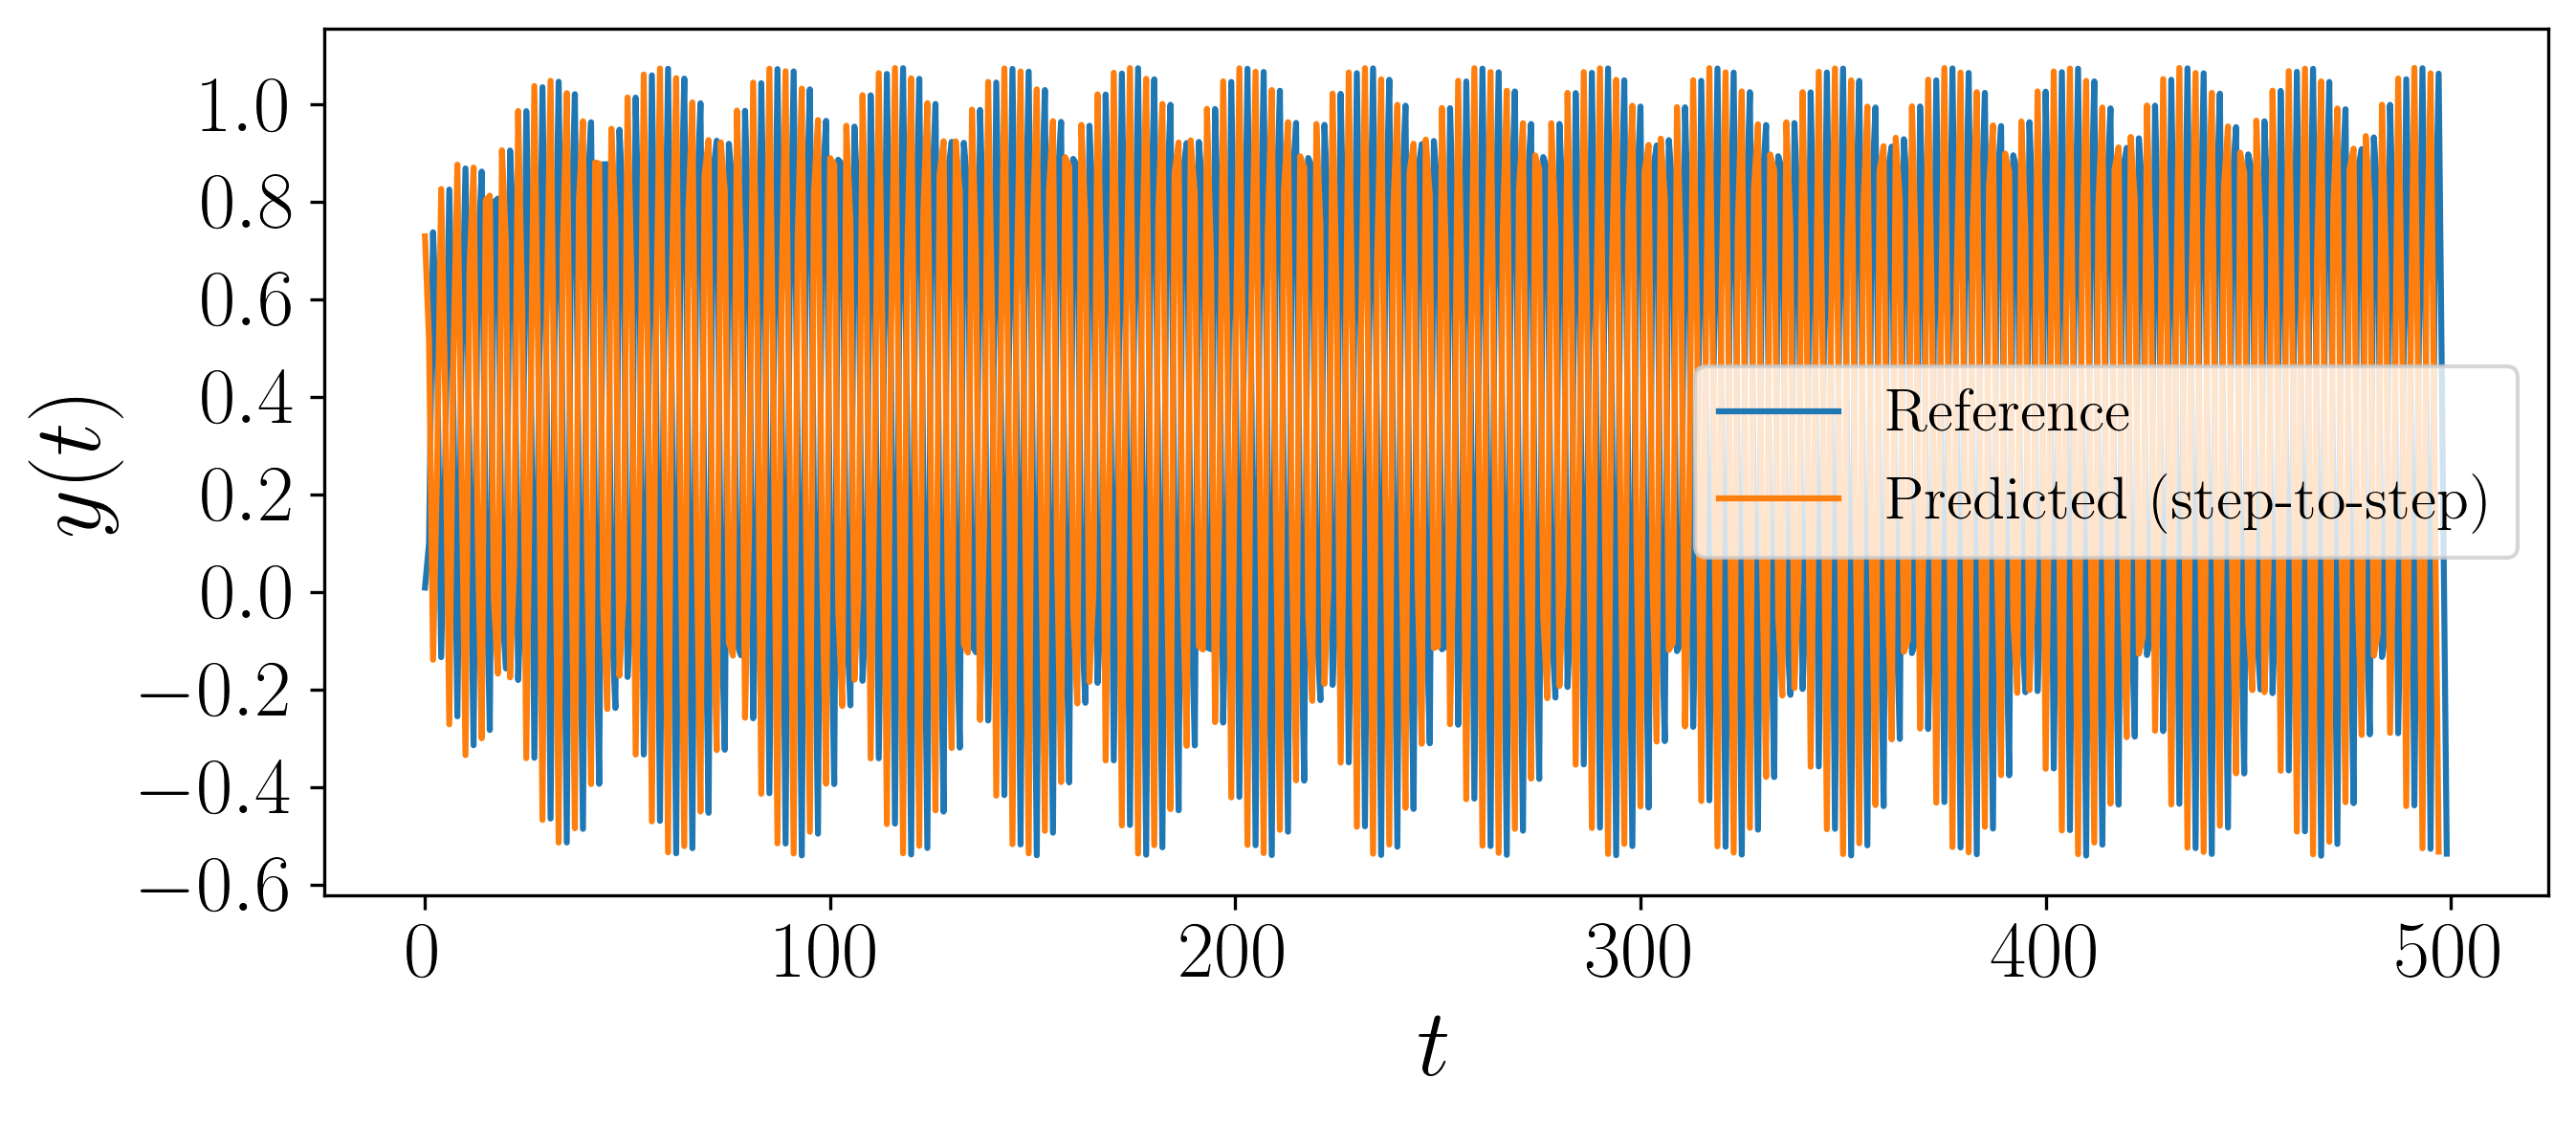

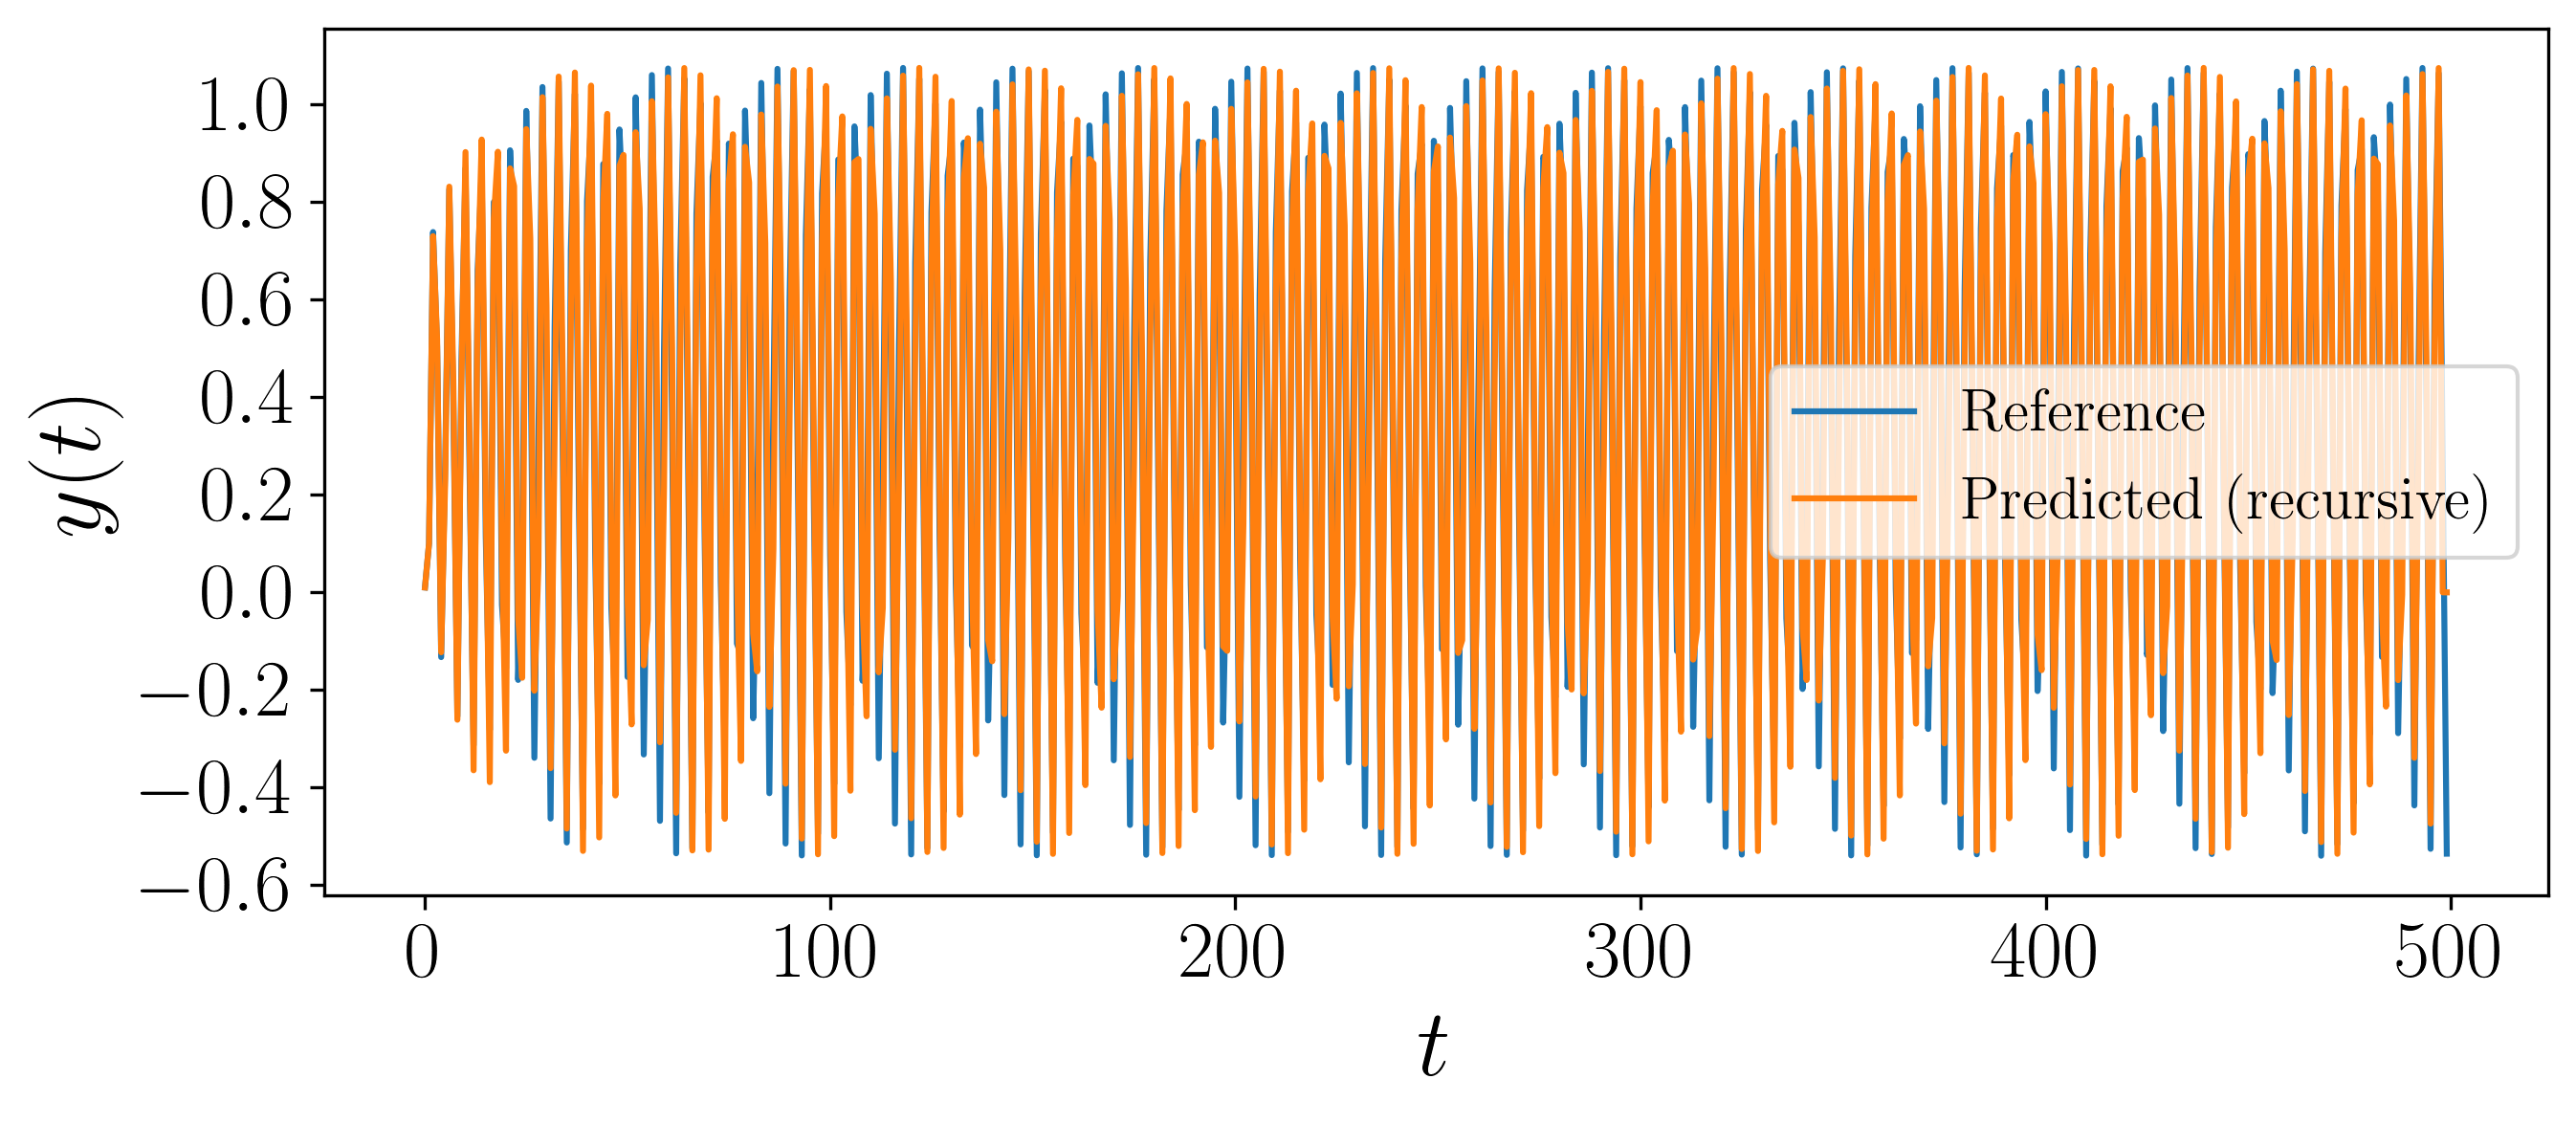

In [54]:
fig = plt.figure(dpi=300,figsize=(10,4))
plt.plot(y_1,label='Reference')
plt.plot(X_2_pred,label='Predicted (step-to-step)')
# plt.plot(X_2_pred_hat,label='Predicted (recursive)')
plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$y(t)$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()

fig = plt.figure(dpi=300,figsize=(10,4))
plt.plot(y_1,label='Reference')
# plt.plot(X_2_pred,label='Predicted (step-to-step)')
plt.plot(X_2_pred_hat,label='Predicted (recursive)')
plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$y(t)$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()